# Exercise 4: Circuit Decomposition
Wow! If you managed to solve the first three exercises, congratulations! The fourth problem is supposed to puzzle even the quantum experts among you, so don’t worry if you cannot solve it. If you can, hats off to you!

You may recall from your quantum mechanics course that quantum theory is unitary. Therefore, the evolution of any (closed) system can be described by a unitary. But given an arbitrary unitary, can you actually implement it on your quantum computer?

**"A set of quantum gates is said to be universal if any unitary transformation of the quantum data can be efficiently approximated arbitrarily well as a sequence of gates in the set."** (https://qiskit.org/textbook/ch-algorithms/defining-quantum-circuits.html)

Every gate you run on the IBM Quantum Experience is transpiled into single qubit rotations and CNOT (CX) gates. We know that these constitute a universal gate set, which implies that any unitary can be implemented using only these gates. However, in general it is not easy to find a good decomposition for an arbitrary unitary. Your task is to find such a decomposition.

You are given the following unitary:

In [2]:
from may4_challenge.ex4 import get_unitary
U = get_unitary()
# print(U)
print("U has shape", U.shape)

U has shape (16, 16)


#### What circuit would make such a complicated unitary?

Is there some symmetry, or is it random? We just updated Qiskit with the introduction of a quantum circuit library (https://github.com/Qiskit/qiskit-terra/tree/master/qiskit/circuit/library). This library gives users access to a rich set of well-studied circuit families, instances of which can be used as benchmarks (quantum volume), as building blocks in building more complex circuits (adders), or as tools to explore quantum computational advantage over classical computation (instantaneous quantum polynomial complexity circuits).

In [3]:
from qiskit import QuantumCircuit
from may4_challenge.ex4 import check_circuit, submit_circuit

#additional deps for learning and exploring the problem
%matplotlib inline

from qiskit import *
from qiskit.quantum_info import Operator
import numpy as np
import scipy as scipy
import sympy as sym
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler import PassManager
from qiskit.extensions import UnitaryGate
from scipy.ndimage.interpolation import rotate
from may4_challenge.ex4 import check_circuit, submit_circuit
from scipy.linalg import hadamard
import math
from cmath import rect
from sympy.physics.quantum.state import *
from IPython.display import display, Math, HTML, display_latex
from qiskit.visualization import plot_gate_map
from qiskit.tools.visualization import *

sym.init_printing()
%config InlineBackend.figure_format = 'retina' # to print nice and crisp graphs. believe me.
display(HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    align-items: center;
}
</style>
"""))

**Using only single qubit rotations and CNOT gates, find a quantum circuit that approximates that unitary $U$ by a unitary $V$ up to an error $\varepsilon = 0.01$, such that $\lVert U - V\rVert_2 \leq \varepsilon$ !** 

Note that the norm we are using here is the spectral norm, $\qquad \lVert A \rVert_2 = \max_{\lVert \psi \rVert_2= 1} \lVert A \psi \rVert$.

This can be seen as the largest scaling factor that the matrix $A$ has on any initial (normalized) state $\psi$. One can show that this norm corresponds to the largest singular value of $A$, i.e., the square root of the largest eigenvalue of the matrix $A^\dagger A$, where $A^{\dagger}$ denotes the conjugate transpose of $A$.

**When you submit a circuit, we remove the global phase of the corresponding unitary $V$ before comparing it with $U$ using the spectral norm. For example, if you submit a circuit that generates $V = \text{e}^{i\theta}U$, we remove the global phase $\text{e}^{i\theta}$ from $V$ before computing the norm, and you will have a successful submission. As a result, you do not have to worry about matching the desired unitary, $U$, up to a global phase.**

As the single-qubit gates have a much higher fidelity than the two-qubit gates, we will look at the number of CNOT-gates, $n_{cx}$, and the number of u3-gates, $n_{u3}$, to determine the cost of your decomposition as 

$$
\qquad \text{cost} = 10 \cdot n_{cx} + n_{u3}
$$

Try to optimize the cost of your decomposition. 

**Note that you will need to ensure that your circuit is composed only of $u3$ and $cx$ gates. The exercise is considered correctly solved if your cost is smaller than 1600.**

---
For useful tips to complete this exercise as well as pointers for communicating with other participants and asking questions, please take a look at the following [repository](https://github.com/qiskit-community/may4_challenge_exercises). You will also find a copy of these exercises, so feel free to edit and experiment with these notebooks.

---

# Solution:

let's define some helper functions and constants to get rid of some code further down

In [107]:
num_qbit = 4
num_qbit_list = list(range(num_qbit))

H = 1/np.sqrt(2)*np.array([[1,1],[1,-1]]) # 1 qubit Hadamard
H4 = np.kron(H,np.kron(H,np.kron(H,H))) # 4 qbuit Hadamard
# The above is for learning purposes. In real life you'd use some helper like the following
# we divide it by 4 to normalize it.
# H4 = hadamard(16, dtype=complex)/4

U_simulator = Aer.get_backend('unitary_simulator')

plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)
    
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

def get_circuit_matrix(qc):
    qc_job = execute(qc, U_simulator)
    qc_result = qc_job.result()
    qc_unitary = qc_result.get_unitary(qc, decimals=3)
    return qc_unitary

def to_sympy_matrix(M, constants=(), tolerance=None):
    ret = M
    ret = np.around(ret, 8)
    ret = vnsimplify(ret, constants=constants, tolerance=tolerance)
    ret = vsimplify(ret)
    return ret

def norm_2(unitary_a: np.ndarray, unitary_b: np.ndarray) -> float:
    return np.linalg.norm(
        without_global_phase(unitary_b)-without_global_phase(unitary_a), ord=2)

def without_global_phase(matrix: np.ndarray, atol: float = 1e-8) -> np.ndarray:
    phases1 = np.angle(matrix[abs(matrix) > atol].ravel(order='F'))
    if len(phases1) > 0:
        matrix = np.exp(-1j * phases1[0]) * matrix
    return matrix

def prove_circuit_identity(qc_a, qc_b, circuit_margin=[2.0, 0, 0, 0.3], draw_matrix=True, grid_width_ratios=[5, 1, 5, 1, 5], constants=(), tolerance=None, ignore_global_phase=False):
    qc_a_unitary = get_circuit_matrix(qc_a)
    qc_b_unitary = get_circuit_matrix(qc_b)
    
    AeqB = False
    
    if ignore_global_phase:
        epsilon = 0.01
        qc_a_unitary = without_global_phase(qc_a_unitary, 3)
        #qc_a_unitary = np.around(qc_a_unitary, 3)
        qc_b_unitary = without_global_phase(qc_b_unitary, 3)
        #qc_b_unitary = np.around(qc_b_unitary, 3)
        AeqB = norm_2(qc_a_unitary, qc_b_unitary) <= epsilon
    else: 
        AeqB = np.array_equal(qc_a_unitary, qc_b_unitary)
    
    AeqB_Str = "yes" if AeqB else "no"
    print("Does circuit A matrix equals circuit B matrix? {}".format(AeqB_Str))
    
    plots_len = 5
    
    plots_len -= 0 if draw_matrix else 2
    
    gs = mpl.gridspec.GridSpec(1, plots_len, width_ratios=grid_width_ratios)
    fig, ax = plt.subplots(1, plots_len)
    ax[0] = plt.subplot(gs[0, 0])
    ax[1] = plt.subplot(gs[0, 1])
    ax[2] = plt.subplot(gs[0, 2])
    set_size(15, 2, ax=ax[0])
    qc_a.draw(output='mpl', ax=ax[0], scale=1, style={'figwidth': 15, 'margin': circuit_margin})
    set_size(15, 2, ax=ax[0])
    mpl.pyplot.text(0.5, 0.5, r'${}$'.format(r'=' if AeqB else r'\neq'), horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=25)
    ax[1].axis('off')
    qc_b.draw(output='mpl', ax=ax[2], scale=1, style={'figwidth': 15, 'margin': circuit_margin})
    set_size(15, 2, ax=ax[2])
    if draw_matrix: 
        qc_a_unitary_sym = to_sympy_matrix(qc_a_unitary, constants=constants, tolerance=tolerance)
        qc_b_unitary_sym = to_sympy_matrix(qc_b_unitary, constants=constants, tolerance=tolerance)
        mpl.pyplot.text(0.5, 0.5, r'$=$', horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes, fontsize=25)
        ax[3].axis('off')
        qc_a_unitary_latex = r'${}$'.format(sym.latex(sym.Matrix(qc_b_unitary_sym)))
        mpl.pyplot.text(0.5, 0.5, qc_a_unitary_latex, horizontalalignment='center', verticalalignment='center', transform=ax[4].transAxes, fontsize=25)
        ax[4].axis('off')

def plot_matrix(mat, plot_type='default'):
    if plot_type == 'heatmap' or plot_type == 'default' or plot_type == 'all':
        fig, axs = mpl.pyplot.subplots(1, 2, figsize=(20, 8))
        im1 = axs[0].imshow(np.abs(mat), cmap='hot', interpolation='bilinear', vmin=0, vmax=1)
        axs[0].set_title('Magnitude')
        fig.colorbar(im1, ax=axs[0])
        im2 = axs[1].imshow(np.angle(mat), cmap='hot', interpolation='bilinear', vmin=-np.pi, vmax=np.pi)
        axs[1].set_title('Phase')
        fig.colorbar(im2, ax=axs[1])

    if plot_type == 'sns' or plot_type == 'all':
        fig, ax = mpl.pyplot.subplots(1, 2, figsize=(20, 8))
        sns.heatmap(np.abs(mat), annot=True, fmt = '0.2f', linewidths=.5, ax=ax[0])
        ax[0].set_title('Magnitude')
        sns.heatmap(np.angle(mat), annot=True, fmt = '0.2f', linewidths=.5, ax=ax[1])
        ax[1].set_title('Phase')
    
    mpl.pyplot.show()

def plot_circuit(qc):
    plot_matrix(Operator(qc).data)

def gen_table(data, collabel, figsize, font_size, table_scale):
    fig = plt.figure(figsize=figsize, linewidth=1)#dpi=200
    ax = fig.add_subplot(1,1,1)
    mpl.rcParams['mathtext.fontset'] = 'cm'
    mpl.rcParams['mathtext.rm'] = 'serif'
    table = ax.table(cellText=table_data, colLabels=collabel, loc='center')
    plt.rc('lines', linewidth=3)
    table.set_fontsize(font_size)
    table.scale(table_scale[0], table_scale[1])
    ax.axis('off')

# Reference: https://github.com/zjiang23/CS269Q-RQSS/blob/master/qft.py
# Reference: https://courses.edx.org/c4x/BerkeleyX/CS191x/asset/chap5.pdf (Page 2)
def QFT_mat2(n):
    omega = np.exp(2.0 * np.pi * 1j / n)
    mat = np.ones((n, n), dtype=complex)
    
    for i in range(1, n):
        for j in range(1, n):
            mat[i, j] = omega ** (i * j)

    mat /= math.sqrt(float(n))
    return mat

def QFT_mat(n):
    NN = 2**n
    QFN = np.zeros([NN,NN],dtype=np.complex_)
    for i in range(NN):
        for j in range(NN):
            if (i == 0) or (j == 0):
                QFN[i,j] = 1
            else:
                QFN[i,j] = np.exp((2*np.pi*1j)*(i*j)/NN)
    return QFN

# The following for loop is to replace very small values ( < 1e-14) from computational error with zero,
# this way when calculating the phase we will get zero rather than random values
def filter_mat(m):
    m_ret = np.zeros(shape=m.shape, dtype=m.dtype)
    for i in range(len(m)):
        for j in range(len(m[i])):
            m_ret[i,j] = m[i,j]
            if 0 < np.real(m_ret[i,j]) < 1e-14:
                m_ret[i,j] = 0 + 1j*(np.imag(m_ret[i,j]))
            if -1e-14 < np.real(m_ret[i,j]) < 0:
                m_ret[i,j] = 0 + 1j*(np.imag(m_ret[i,j]))
            if 0 < np.imag(m_ret[i,j]) < 1e-14:
                m_ret[i,j] = np.real(m_ret[i,j]) + 1j*0
            if -1e-14 < np.imag(m_ret[i,j]) < 1e-14:
                m_ret[i,j] = np.real(m_ret[i,j]) + 1j*0
    return m_ret

def rad_sum(a, b):
    sinAB = sym.sin(a) * sym.cos(b) + sym.cos(a) * sym.sin(b)
    cosAB = sym.cos(a) * sym.cos(b) - sym.sin(a) * sym.sin(b)
    return sym.atan2(sinAB, cosAB)

def to_polar_exp(val, constants=(), tolerance=None):
    R = np.abs(val)
    theta = np.angle(val)
    R_sym = sym.nsimplify(R, constants=constants, tolerance=tolerance)
    theta_sym = sym.nsimplify(theta, constants=constants, tolerance=tolerance)
    res = sym.sympify('R*exp(I*theta)',locals={'R':R_sym,'theta':theta_sym}, evaluate=False)
    return res

real2rational = np.vectorize(sym.Rational)
vsimplify = np.vectorize(sym.simplify)
vnsimplify = np.vectorize(sym.nsimplify, excluded=['constants'])
v_to_polar_exp = np.vectorize(to_polar_exp, excluded=['constants', 'tolerance'])
m_rad_sum = np.vectorize(rad_sum)

Let's try to break down what we need to do in order to have a starting point where the check_circuit function happily validates our input.
1. Create a quantum circuit
2. Append the Unitary matrix to it
3. Transpile (aka "translate") it in order to have only u3 and cx gates as per requested
4. Pass it to the check_circuit function

Questions are:
1. Why do we need to transpile/optimize our circuit?  
 Depending on the quantum computer you're going to select as your backend you might or might not have certain gates available. 
 This is known as available `native gate set`.  
 We need therefore to "translate" our circuit in a set of gates our quantum computer features.
 
 Moreover if we try and plot Vigo backend `gate map` as instance, we can see there cannot be interactions between gate 2 and gates other than 1. Also 0 cannot interact with 4 and so on.

 You can find more info here: https://qiskit.org/documentation/stubs/qiskit.compiler.transpile.html

backend native gate set: ['u1', 'u2', 'u3', 'cx', 'id']


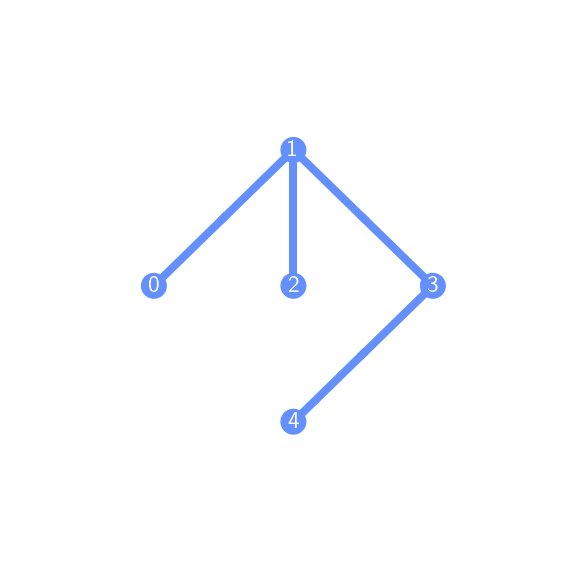

In [108]:
provider = IBMQ.load_account()
accountProvider = IBMQ.get_provider(hub='ibm-q')
backend = accountProvider.get_backend('ibmq_vigo')
backend_configuration = backend.configuration()
backend_properties = backend.properties()
print("backend native gate set: {}".format(backend_configuration.basis_gates))
plot_gate_map(backend)

2. What is an Unitary matrix anyway? What other kind of matrix exists?  
 An answer can be found here: http://fourier.eng.hmc.edu/e161/lectures/algebra/node4.html  
 `A matrix is a unitary matrix if its conjugate transpose is equal to its inverse`  
 Ok, let's check this:

In [165]:
u_conj_transpose = U.transpose().conj()
u_inverse = np.power(U, -1)
# u_inverse = np.power(u_conj_transpose, -1) # this doesn't work either
(u_inverse == u_conj_transpose).all()

False

  Well, that's interesting... Thoughts? Please provide feedbacks so I can update this with an explaination.
  Let's move forward.  
  Why are we presented an Unitary matrix and what does it have anything to do with Quantum Computing?  
  A use case could be a smart Chemistry guy translated his molecule problem into a Unitary matrix and he needs you to give him back QC results.  
  Another use case could be for financial predictions. Same scenario: A guy models its problem as a unitary and asks you to feed it into a quantum computer.
3. How do we append an Unitary matrix to a circuit?
 Well this depends on its properties. Let's see how this matrix looks like

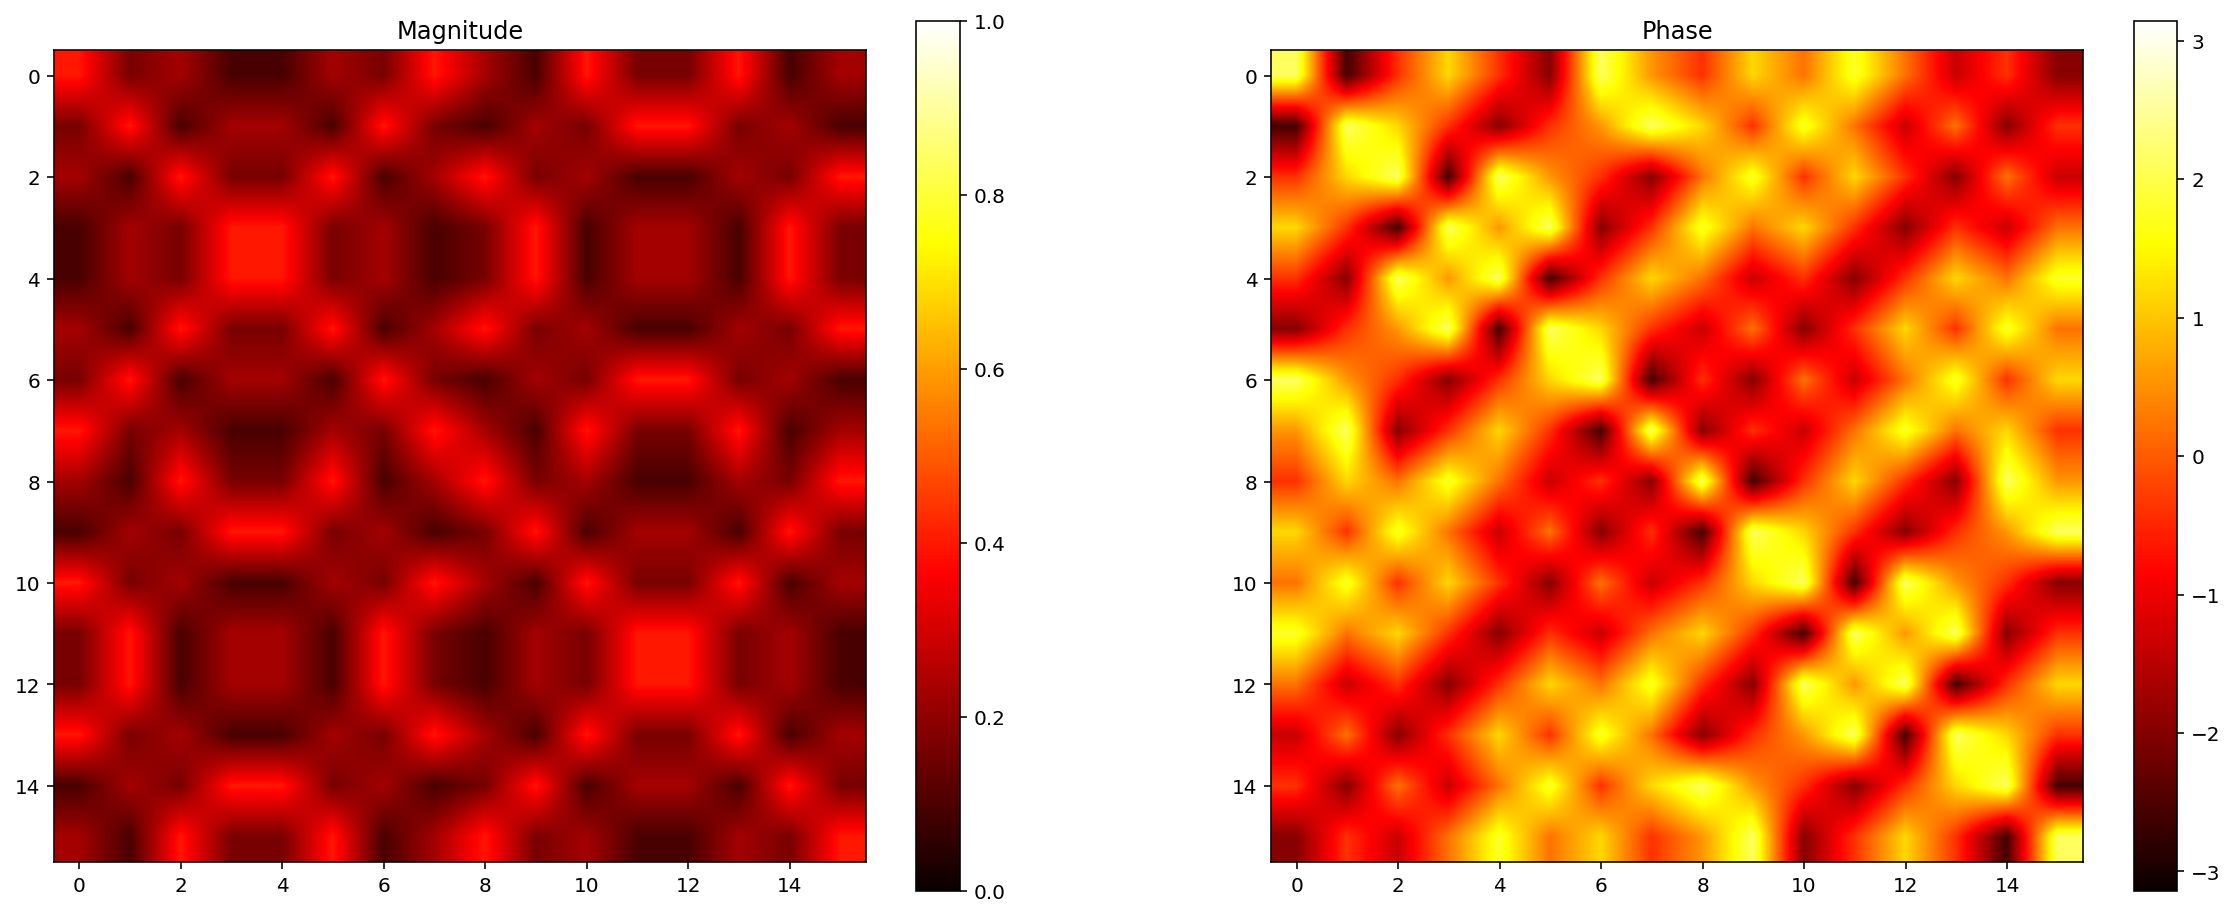

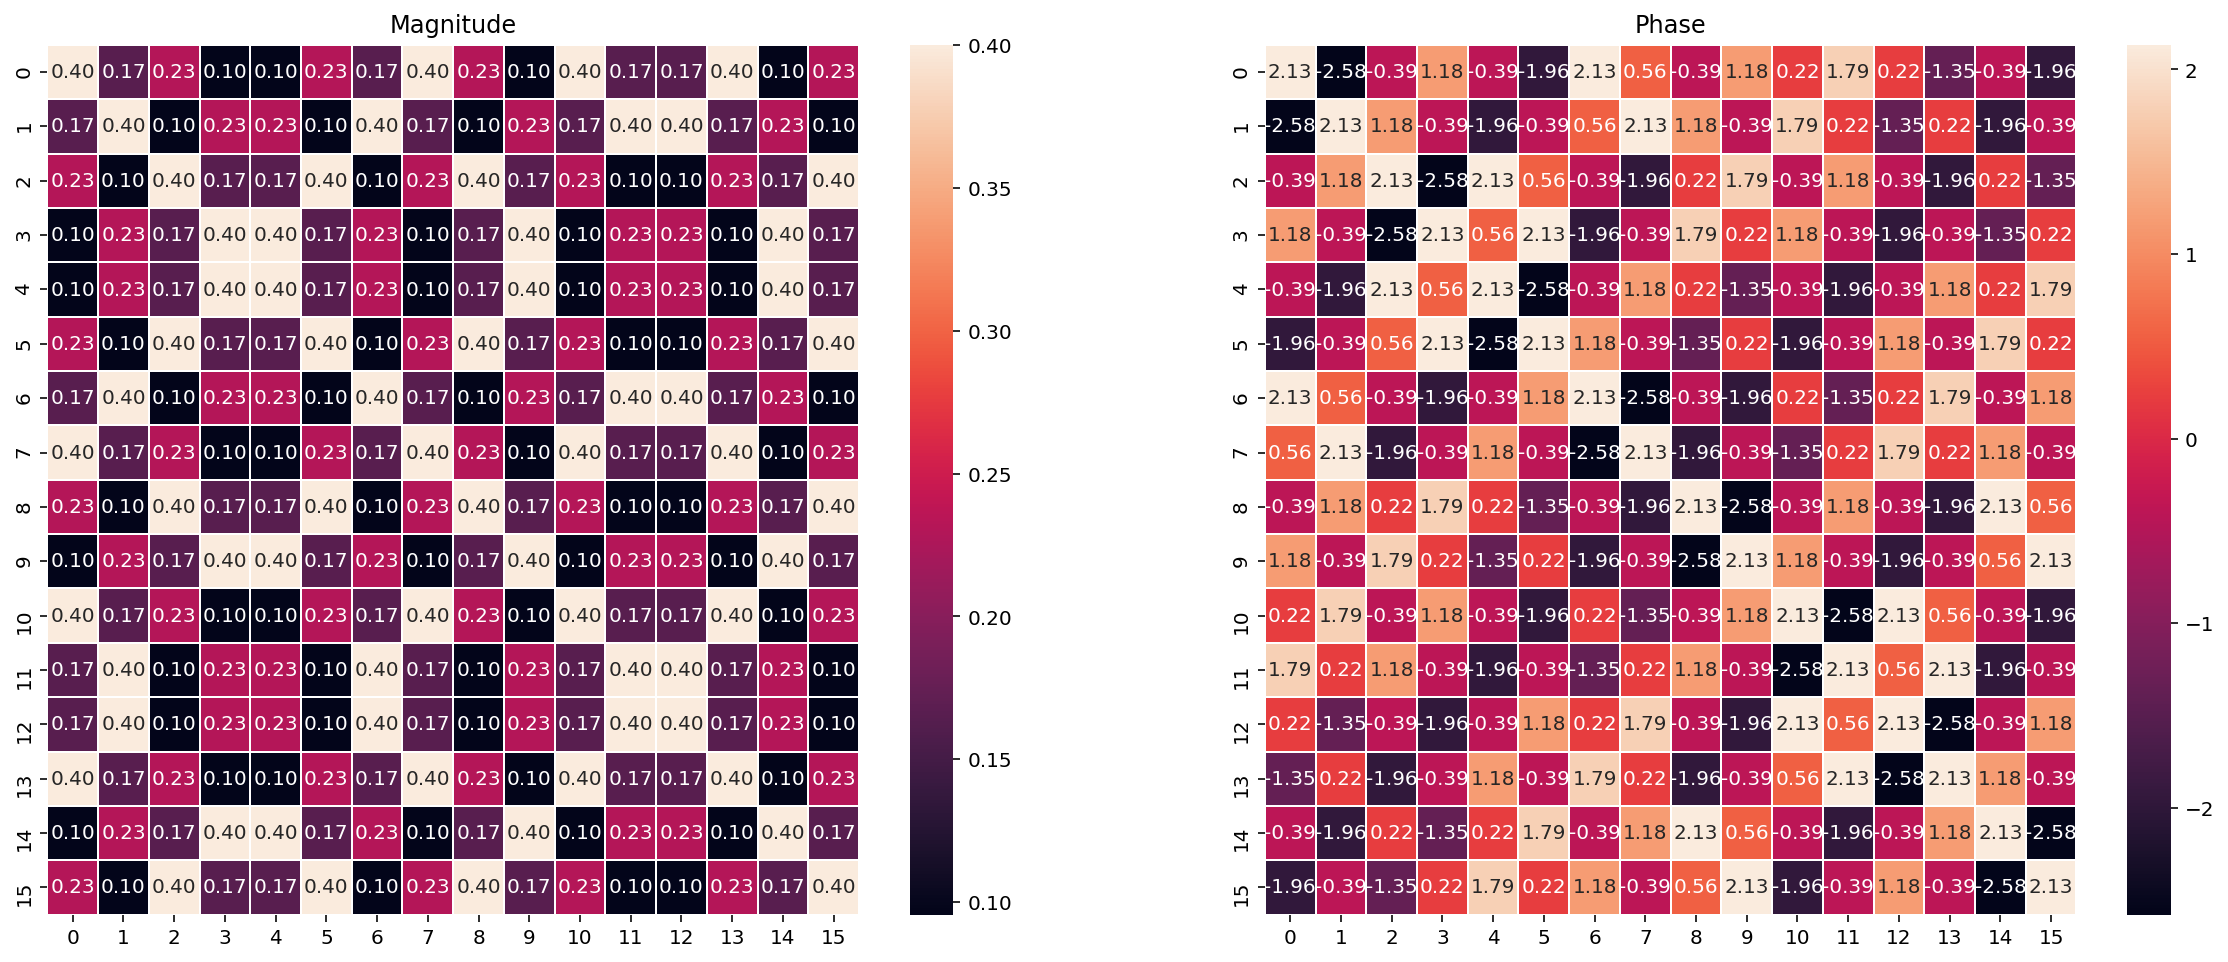

In [97]:
plot_matrix(U, plot_type='all')

If you pay close attention to it, you can see that if you fold it in half across its diagonal (top-left to bottom right) you have values which are touching their corresponding one on the other side.  
You can also look at it as if in the middle there was a mirror.  
This is called an 'isometry' https://en.wikipedia.org/wiki/Isometry
Maybe there's a way to append an isometry to a quantum circuit in Qiskit.  
If you google "qiskit isometry" you'll certainly find this: https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.isometry.html (.iso() and .isometry() are the same function. More precisely .iso() is an alias of .isometry())  
So let's try to append this isometric matrix to our quantum circuit and let's see what we come up with:

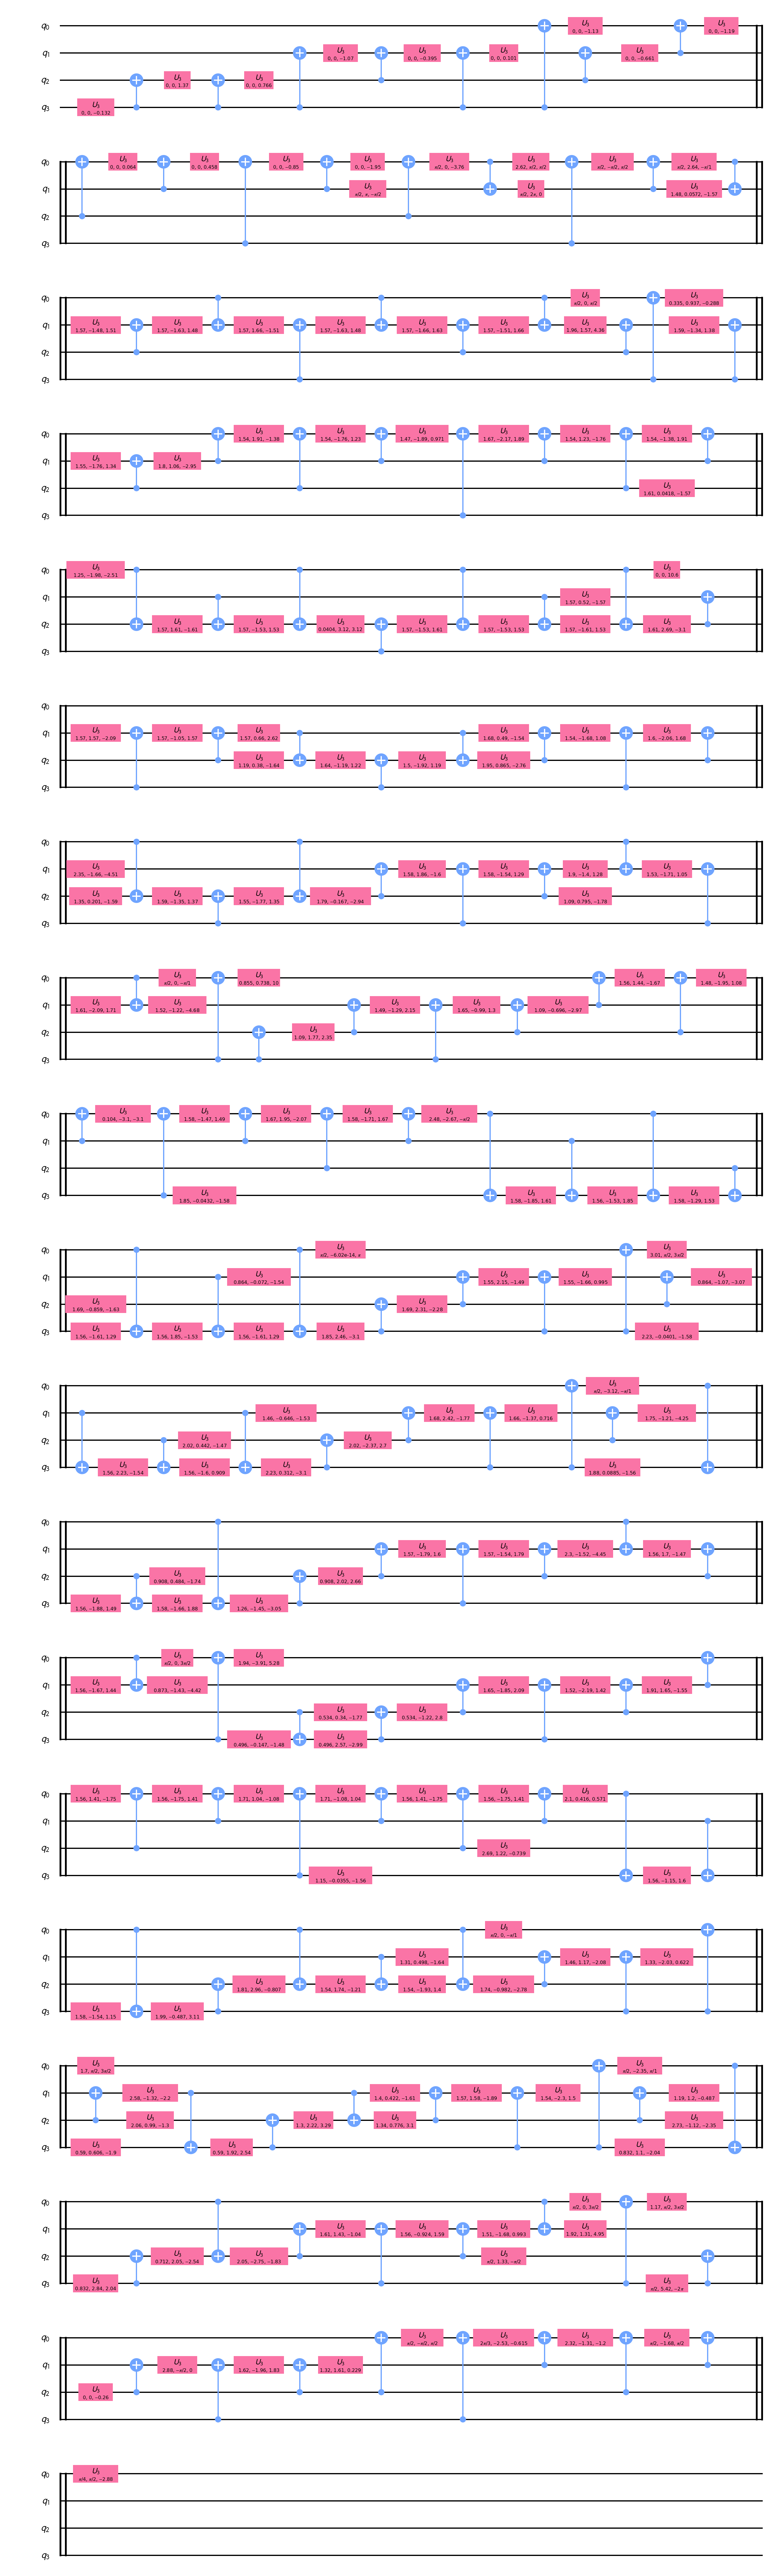

In [101]:
def unoptimized():
    # 1. Create a quantum circuit
    qc = QuantumCircuit(4)
    # 2. Append the unitary matrix to it
    qc.iso(U,[0,1,2,3],[])
    # 3. Transpile (aka "translate") it in order to have only u3 and cx gates as per requested
    qc_transpiled = transpile(qc, basis_gates=['u3','cx'], optimization_level=3)
    return qc_transpiled

qc = unoptimized()
qc.draw(output='mpl')

Wow this circuit it's massive! Let's check how's the situation:

In [102]:
# 4. Pass it to the check_circuit function
check_circuit(qc)

Circuit stats:
||U-V||_2 = 2.737294473846746e-12
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 1676

Something is not right with your circuit: the cost of the circuit is too high (above 1600)


Ok at least we have a starting point. Nice, let's try and explore it a bit.
Can we do the same thingy we did in exercise 1? You mean plotting the simulated statevector? Sure!

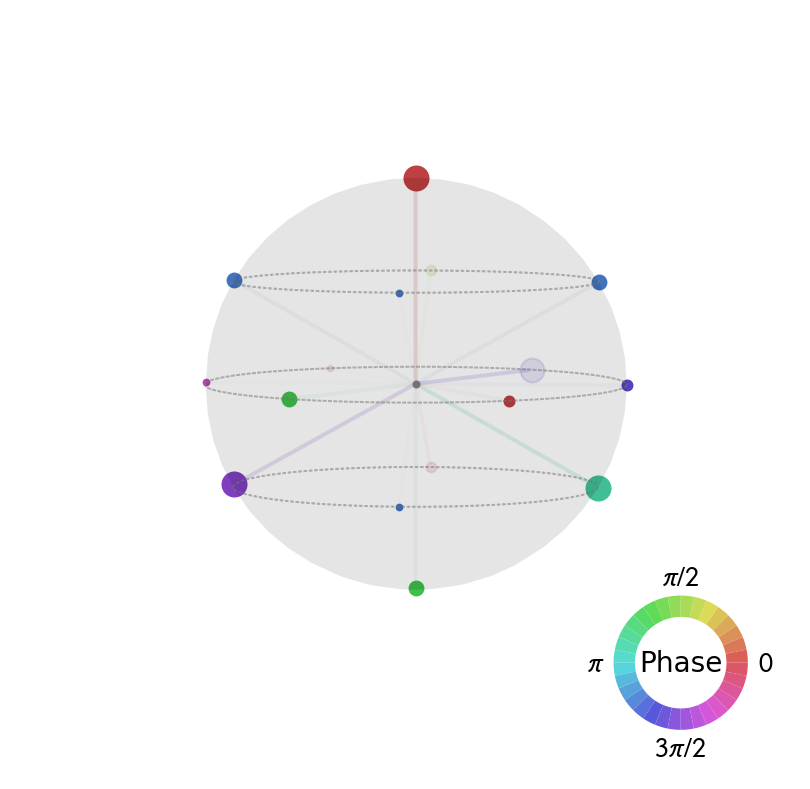

In [103]:
backend = BasicAer.get_backend('statevector_simulator')
result = execute(qc, backend).result()
psi = result.get_statevector(qc)
plot_state_qsphere(psi)

How about the bloch sphere of each qbit?

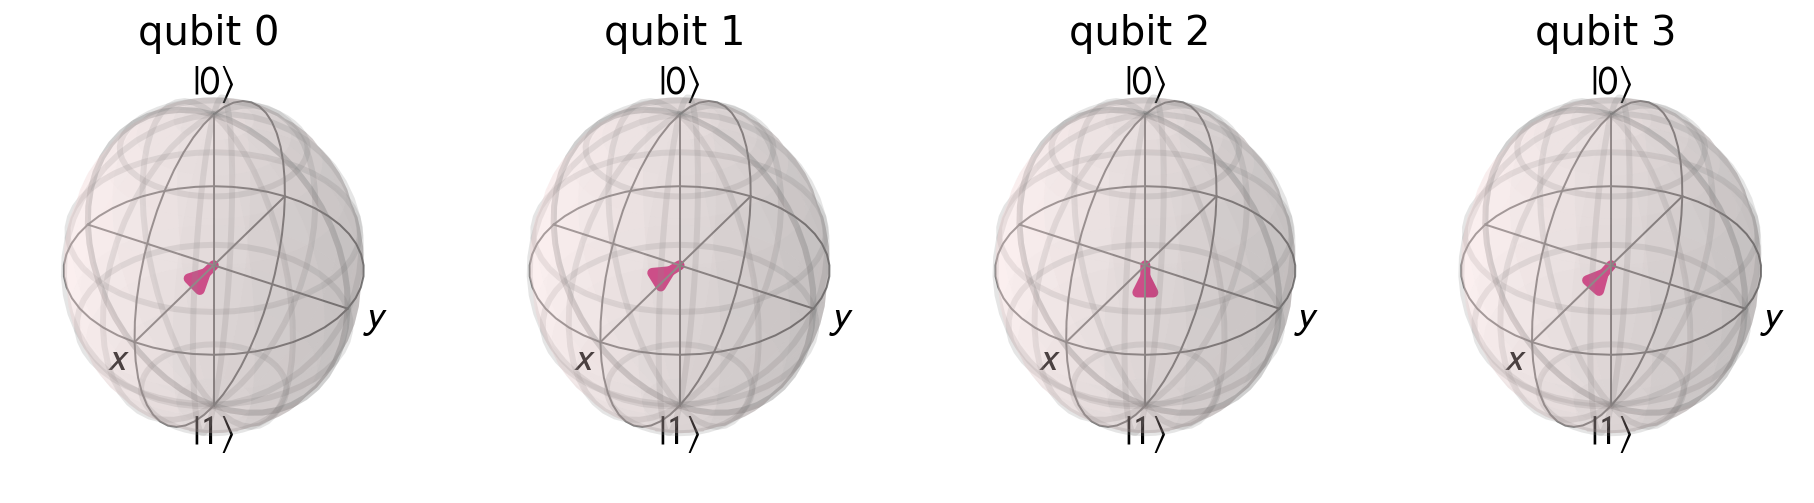

In [104]:
plot_bloch_multivector(psi)

Anyway, we need to chunk this down. Solution to ex3 tells us to use solution from ex1.  
[104, 52, 100, 97, 109, 65, 114, 100]  
Let's convert this into ASCII chars:

In [205]:
solution_ex1 = [104, 52, 100, 97, 109, 65, 114, 100]
"".join([chr(char) for char in solution_ex1])

'h4damArd'

Hadamard, ok. Let's throw it in the circuit to see what happens:

In [169]:
def optimized1():
    qc = QuantumCircuit(4)
    HU = np.matmul(H4, U)
    qc.iso(HU,num_qbit_list,[])
    qc.h(num_qbit_list)
    qc_t = transpile(qc, basis_gates=['u3','cx'], optimization_level=3)
    return qc_t

qc = optimized1()
check_circuit(qc)

Circuit stats:
||U-V||_2 = 7.395610330596521e-08
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 1449

Great! Your circuit meets all the constrains.
Your score is 1449. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


Great! Our circuit meets all the constrains.  
If you got this far during the challenge and you feel like calling it a day you can stop here and submit your answer.
This is what I did, since I was new to this field and I considered it a very good result.
But let's see if we can improve on minimum requirements and learn something from other people's solution.

From here onward we'll follow the approach Diego Emilio Serrano used to get one of the lowest score which amounts to 46. You can find his solution here https://github.com/diemilio/IBM_2020Challenge_Solutions/blob/master/Challenge4_CircuitDecomposition_Solution.ipynb  
There were few points I had trouble following due to my lack of knowledge so I integrated here what helped me developing some intuition about his reasoning.

He suggests at this point to take a look at the unitary matrix in Fourier space, to see if we notice anything interesting in what you can think of its "composing frequencies":

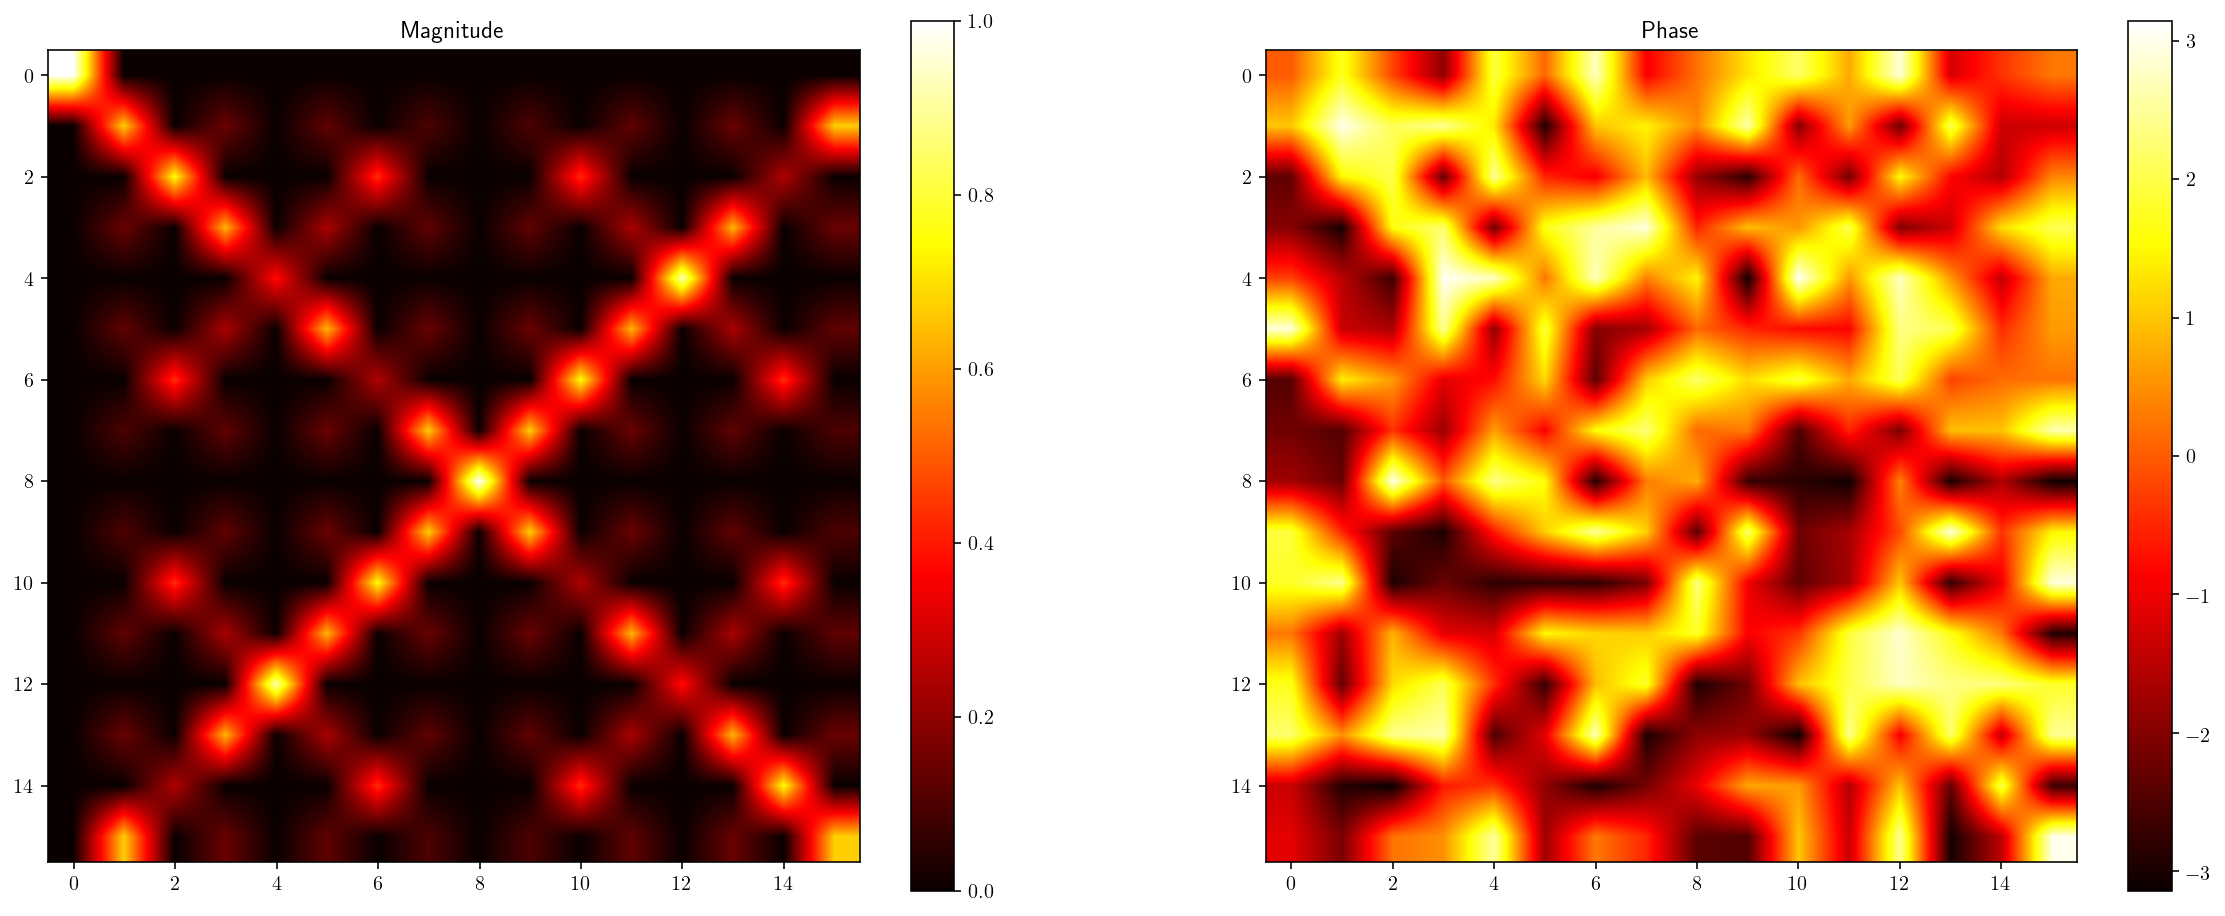

In [109]:
QF4 = QFT_mat(4) # 4 qubit QFT matrix
QF4_inv = np.linalg.inv(QF4) # 4 qubit inverse QFT matrix
QUQ = np.matmul(QF4_inv,np.matmul(U,QF4))
plot_matrix(QUQ, plot_type='heatmap')

mmm... Phase graph is on fire. Let's denoise it a bit by removing negligible values

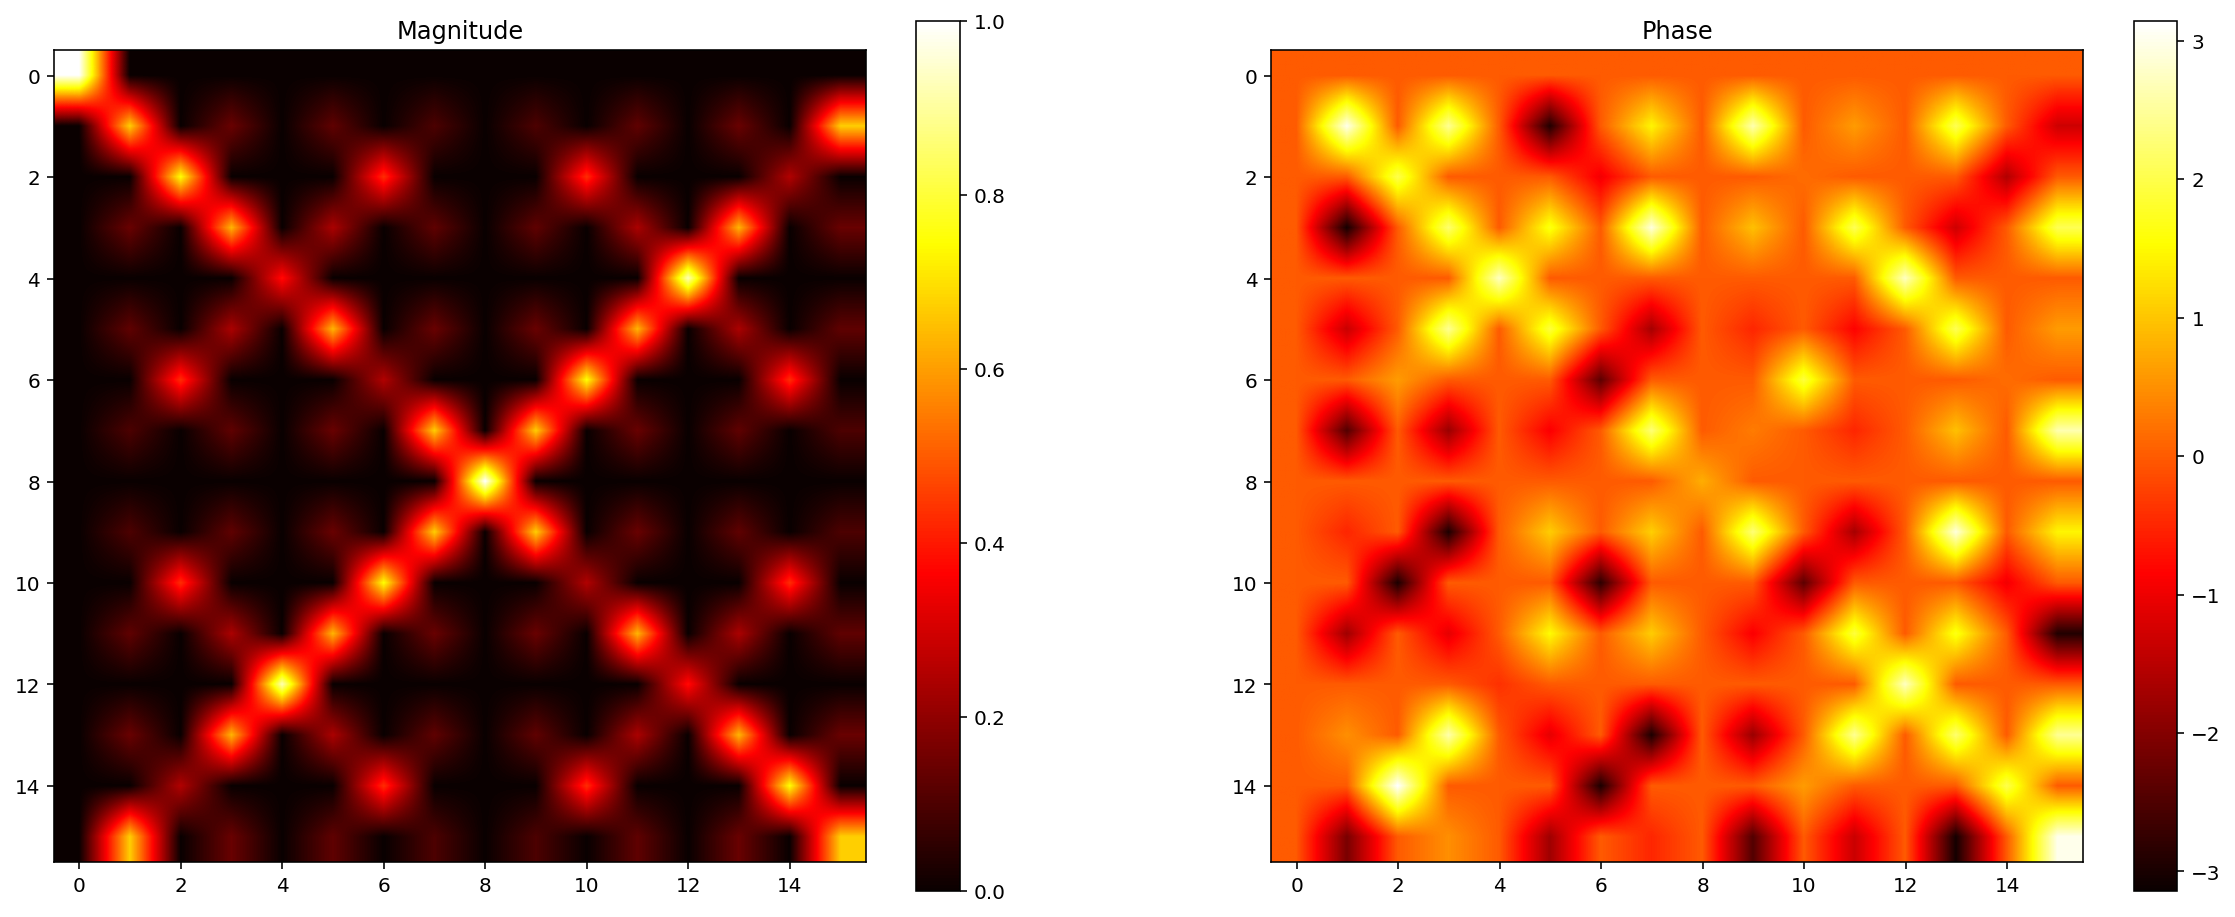

In [181]:
QUQ.real[abs(QUQ.real) < 1e-14] = 0.0
QUQ.imag[abs(QUQ.imag) < 1e-14] = 0.0
plot_matrix(QUQ, plot_type='heatmap')

Looks better. We can clearly see values across diagonals being highlighted.  
So let's try to throw in the mix the Hadamard Gate as before and see what happens.

In [170]:
def optimized2():
    UH = np.matmul(U,H4)
    UH.real[abs(UH.real) < 1e-14] = 0.0
    UH.imag[abs(UH.imag) < 1e-14] = 0.0
    
    qc = QuantumCircuit(num_qbit)
    qc.h(num_qbit_list)
    qc.iso(UH, num_qbit_list, [])
    qc_t = transpile(qc, basis_gates = ['u3', 'cx'], optimization_level=2,)
    
    return qc_t

qc = optimized2()
check_circuit(qc)

Circuit stats:
||U-V||_2 = 7.31201725589293e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 351

Great! Your circuit meets all the constrains.
Your score is 351. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


Good, let's try and improve on this. We do it by moving it in Hadarmad space. In other terms we apply Hadamard gates before and after our circuit to give a chance to the optimizer to do its magic.  
This is what is called an Instantaneous Quantum Polynomial (IQP) circuit https://qiskit.org/documentation/stubs/qiskit.circuit.library.IQP.html

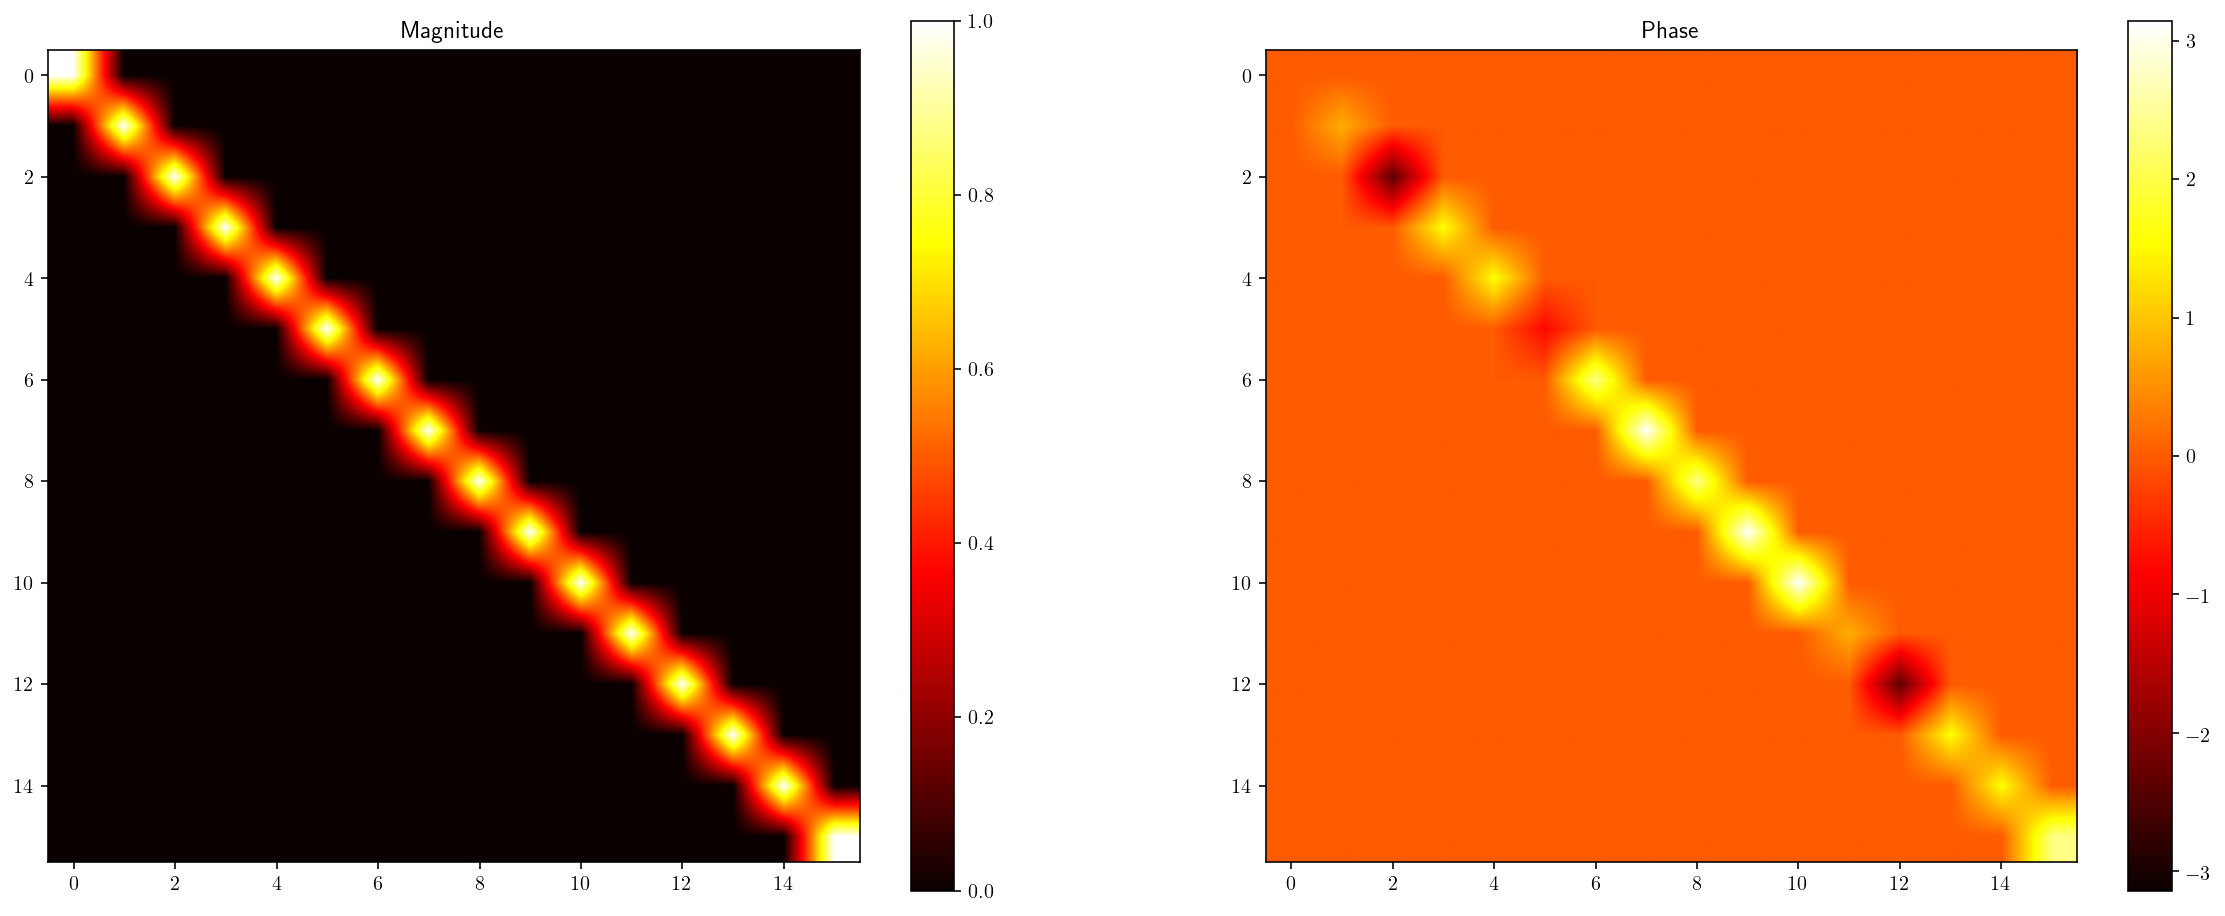

In [138]:
UH = np.matmul(U,H4)
HUH = np.matmul(H4,UH)
HUH.real[abs(HUH.real) < 1e-14] = 0.0
HUH.imag[abs(HUH.imag) < 1e-14] = 0.0
plot_matrix(HUH, 'default')

In [172]:
def optimized3():    
    qc = QuantumCircuit(num_qbit)
    qc.h(num_qbit_list)
    qc.iso(HUH, num_qbit_list, [])
    qc.h(num_qbit_list)
    qc_t = transpile(qc, basis_gates = ['u3', 'cx'], optimization_level=3)
    
    return qc_t

qc = optimized3()
check_circuit(qc)

Circuit stats:
||U-V||_2 = 6.445258714242848e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 107

Great! Your circuit meets all the constrains.
Your score is 107. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


can we do better than this? Yeah, but we need some theory.
Let's consider a unitary similar to ours but simpler; with only 2 qbits:

In [145]:
test_unitary_raw = np.matrix([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, (1/np.sqrt(2))*(1+1j), 0],
    [0, 0, 0, 1]
])
test_unitary = to_sympy_matrix(test_unitary_raw, constants=[sym.sqrt(2), sym.pi], tolerance=0.001)
display(sym.Matrix(test_unitary))

⎡1  0       0       0⎤
⎢                    ⎥
⎢0  -1      0       0⎥
⎢                    ⎥
⎢       √2⋅(1 + ⅈ)   ⎥
⎢0  0   ──────────  0⎥
⎢           2        ⎥
⎢                    ⎥
⎣0  0       0       1⎦

We focus on its diagonal because we're interested in mapping single qbits transitions so we can have a sort of truth table.  
So for its diagonal

In [146]:
test_unitary_diagonal_raw = np.diagonal(test_unitary_raw)
test_unitary_diagonal = to_sympy_matrix(test_unitary_diagonal_raw, constants=[sym.sqrt(2), sym.pi], tolerance=0.001)
display(sym.Matrix(np.matrix([test_unitary_diagonal])))

⎡       √2⋅(1 + ⅈ)   ⎤
⎢1  -1  ──────────  1⎥
⎣           2        ⎦

We get the following truth table

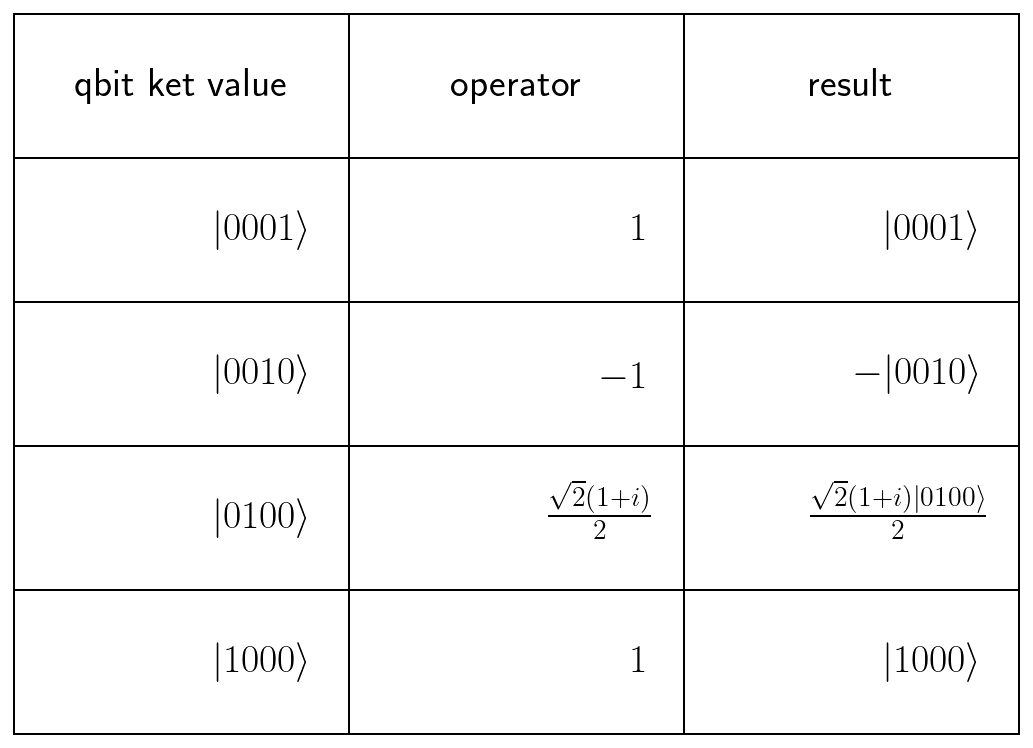

In [132]:
table_data = []

for idx, operator in enumerate(test_unitary_diagonal):
    ketval = 0b1 << idx
    ket_args = [int(x) for x in '{:04b}'.format(ketval)]
    ket_val = Ket(*ket_args)
    ket_val_latex = r"${}$".format(sym.latex(ket_val))
    operator_latex = r"${}$".format(sym.latex(operator))
    result_latex = r"${}$".format(sym.latex(operator * ket_val))
    table_data.append([ket_val_latex, operator_latex, result_latex])

collabel=("qbit ket value", "operator", "result")
gen_table(table_data, collabel, figsize=(3,6), font_size=20, table_scale=(3,6))

plt.show()

#display(Math(sym.latex(Ket(1, 2))))
#display(Math(sym.latex(test_circuit_unitary_diagonal[0])))
#display(sym.Rational(sym.N(test_circuit_unitary_diagonal[0])))
#display(sym.dsolve(sym.N(test_circuit_unitary_diagonal[0])))

Or we can say we add the following relative phase to each state

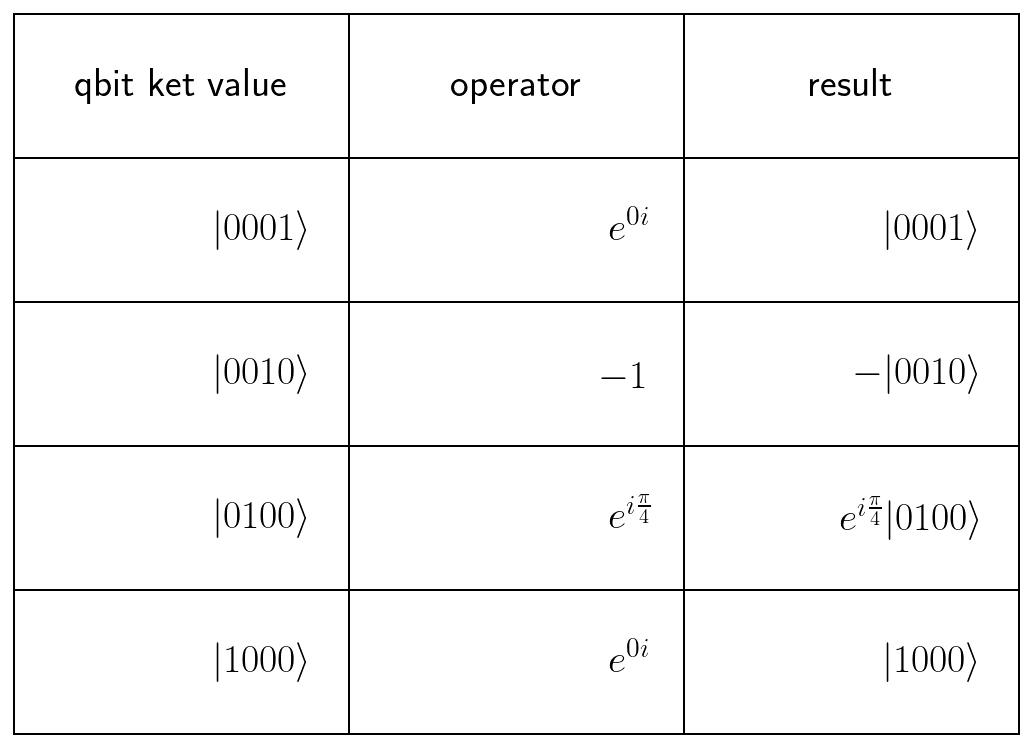

In [133]:
table_data = []

test_unitary_diagonal_phase = v_to_polar_exp(test_unitary_diagonal_raw, constants=[sym.sqrt(2), sym.pi])

for idx, operator in enumerate(test_unitary_diagonal_phase):
    ketval = 0b1 << idx
    ket_args = [int(x) for x in '{:04b}'.format(ketval)]
    ket_val = Ket(*ket_args)
    ket_val_latex = r"${}$".format(sym.latex(ket_val))
    operator_latex = r"${}$".format(sym.latex(operator))
    result_latex = r"${}$".format(sym.latex(operator * ket_val))
    table_data.append([ket_val_latex, operator_latex, result_latex])

collabel=("qbit ket value", "operator", "result")
gen_table(table_data, collabel, figsize=(3,6), font_size=20, table_scale=(3,6))
plt.show()

#val = test_circuit_unitary_diagonal_raw[0]

Note: second operator (0010) gets simplified according to: https://www.math.toronto.edu/mathnet/questionCorner/epii.html  
as demonstrated here

In [134]:
val = -1+.0j
val_sym = sym.nsimplify(val, constants=[sym.pi])
R = np.abs(val)
theta = np.angle(val)
R_sym = sym.nsimplify(R, constants=[sym.pi])
theta_sym = sym.nsimplify(theta, constants=[sym.pi])
# i (lowercase) is a cheat to prevent semplification. Real constant is I (uppercase)
exp1 = sym.sympify('R*exp(i*theta)',locals={'R':R_sym,'theta':theta_sym}, evaluate=False)
exp2 = sym.sympify('R*exp(I*theta)',locals={'R':R_sym,'theta':theta_sym}, evaluate=False)
exp3 = r'1e^{\pi i}'
result = "$-1 = {} = {} = {} = {}$".format(sym.latex(val), sym.latex(exp1), exp3, sym.latex(exp2))
display(Math(result))

<IPython.core.display.Math object>

We now perform the exact same operation we did in the example above to our Unitary.  
Let's start by getting the diagonal of our UHU matrix. We can do this because all other elements are 0

In [147]:
HUH_diag = np.diagonal(HUH)
HUH_diag_simplified = to_sympy_matrix(HUH_diag, constants=[sym.sqrt(2), sym.pi], tolerance=0.001)
display(sym.Matrix(np.matrix([HUH_diag_simplified])))

⎡   √2⋅(1 + ⅈ)  -√2⋅(1 + ⅈ)         √2⋅(1 - ⅈ)  √2⋅(-1 + ⅈ)      √2⋅(-1 + ⅈ)  
⎢1  ──────────  ────────────  ⅈ  ⅈ  ──────────  ───────────  -1  ───────────  
⎣       2            2                  2            2                2       

        √2⋅(1 + ⅈ)  -√2⋅(1 + ⅈ)         √2⋅(-1 + ⅈ)⎤
-1  -1  ──────────  ────────────  ⅈ  ⅈ  ───────────⎥
            2            2                   2     ⎦

These terms are in cartesian form $a+ib$ but if we convert them in polar form $re^{\theta i}$ we obtain the following

In [491]:
HUH_diag_polar = v_to_polar_exp(HUH_diag, constants=[sym.sqrt(2), sym.pi])
display(sym.Matrix(np.matrix([HUH_diag_polar])))

⎡         π     -3⋅π            -π      3⋅π         3⋅π             π     -3⋅π
⎢       ⅈ⋅─   ⅈ⋅─────         ⅈ⋅───   ⅈ⋅───       ⅈ⋅───           ⅈ⋅─   ⅈ⋅────
⎢ 0⋅ⅈ     4       4              4       4           4              4       4 
⎣ℯ     ℯ     ℯ         ⅈ  ⅈ  ℯ       ℯ       -1  ℯ       -1  -1  ℯ     ℯ      

            3⋅π⎤
─         ⅈ⋅───⎥
             4 ⎥
   ⅈ  ⅈ  ℯ     ⎦

Note: the $i$ term above comes from the following semplification

In [148]:
exp1 = r'e^{\frac{\pi}{2} i}'
exp2 = sym.sympify('exp(pi/2 * I)', evaluate=False)
result = "${} = {}$".format(sym.latex(exp1), exp2)
display(Math(result))

<IPython.core.display.Math object>

Now, if we consider only the phase shift which will be added to each qbit as per the above example, or in other words consider only the $\theta$ part of the $re^{\theta i}$ equation:

In [149]:
HUH_diag_phases = np.angle(HUH_diag)
HUH_diag_phases_rational = vnsimplify(HUH_diag_phases, constants=[sym.sqrt(2), sym.pi])
display(sym.Matrix(np.matrix([HUH_diag_phases_rational])))

⎡   π  -3⋅π   π  π  -π   3⋅π     3⋅π        π  -3⋅π   π  π  3⋅π⎤
⎢0  ─  ─────  ─  ─  ───  ───  π  ───  π  π  ─  ─────  ─  ─  ───⎥
⎣   4    4    2  2   4    4       4         4    4    2  2   4 ⎦

We can see what phase get's added to each qbit.  
Let's consider now only the phases where one qbit is flipped (power of 2 starting from 1 to num_qbit)

In [152]:
single_qbit_shift = np.array(list(map(lambda x : HUH_diag_phases[x], [1 << i for i in range(num_qbit)])), dtype='float64')
single_qbit_shift_rational = vnsimplify(single_qbit_shift, constants=[sym.sqrt(2), sym.pi])
display(sym.Array(single_qbit_shift_rational))

⎡π  -3⋅π   π  3⋅π⎤
⎢─  ─────  ─  ───⎥
⎣4    4    2   4 ⎦

We can use those phases with an u3 gate to create a circuit which should be similar to our unitary

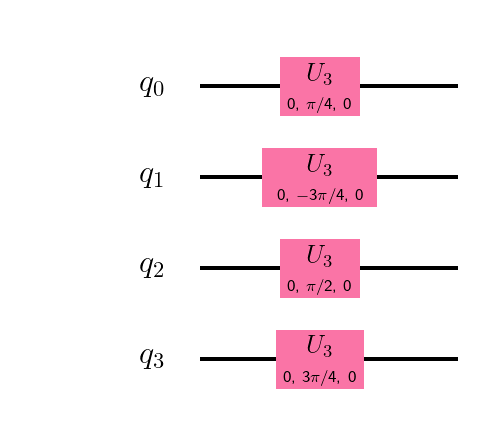

In [153]:
qcp = QuantumCircuit(num_qbit)
for i in range(num_qbit):
    qcp.u3(0,single_qbit_shift[i],0,i)

qcp.draw(output='mpl')

Let's execute it and check its diagonal.  
We care only about the diagonal because the circuit is going to generate a matrix where all the rest of the values are 0

In [155]:
result = execute(qcp, backend = U_simulator).result()
P = result.get_unitary()
P_diag = np.diagonal(P)
P_diag_rational = to_sympy_matrix(P_diag, constants=[sym.sqrt(2), sym.pi], tolerance=0.001)
display(sym.Matrix(np.matrix([P_diag_rational])))

⎡   √2⋅(1 + ⅈ)  -√2⋅(1 + ⅈ)          √2⋅(-1 + ⅈ)  √2⋅(1 - ⅈ)     √2⋅(-1 + ⅈ)  
⎢1  ──────────  ────────────  -ⅈ  ⅈ  ───────────  ──────────  1  ───────────  
⎣       2            2                    2           2               2       

       √2⋅(1 + ⅈ)  -√2⋅(1 + ⅈ)          √2⋅(-1 + ⅈ)⎤
-1  1  ──────────  ────────────  -ⅈ  ⅈ  ───────────⎥
           2            2                    2     ⎦

And again by rewriting them in polar form and considering only $\theta$

In [161]:
P_diag_phases = np.angle(P_diag)
P_diag_phases_rational = to_sympy_matrix(P_diag_phases, constants=[sym.sqrt(2), sym.pi], tolerance=0.001)
display(sym.Matrix(np.matrix([P_diag_phases_rational])))

⎡   π  -3⋅π   -π   π  3⋅π  -π      3⋅π        π  -3⋅π   -π   π  3⋅π⎤
⎢0  ─  ─────  ───  ─  ───  ───  0  ───  π  0  ─  ─────  ───  ─  ───⎥
⎣   4    4     2   2   4    4       4         4    4     2   2   4 ⎦

It seems we're very close with HUH. If we subtrack P to HUH we can see how close we are

In [162]:
phase_diff = m_rad_sum(P_diag_phases_rational, HUH_diag_phases_rational * -1)
display(sym.Matrix(np.matrix([phase_diff])))

[0  0  0  π  0  π  π  π  0  0  π  0  0  π  0  0]

We're so close! we have a circuit causing the exact phase shift (where we see 0) or is off by $\pi$  
We can use z gates to conditionally compensate those $\pi$.  
If we put in a table all the possible states we can see across which qbits we need to apply a cz gate.

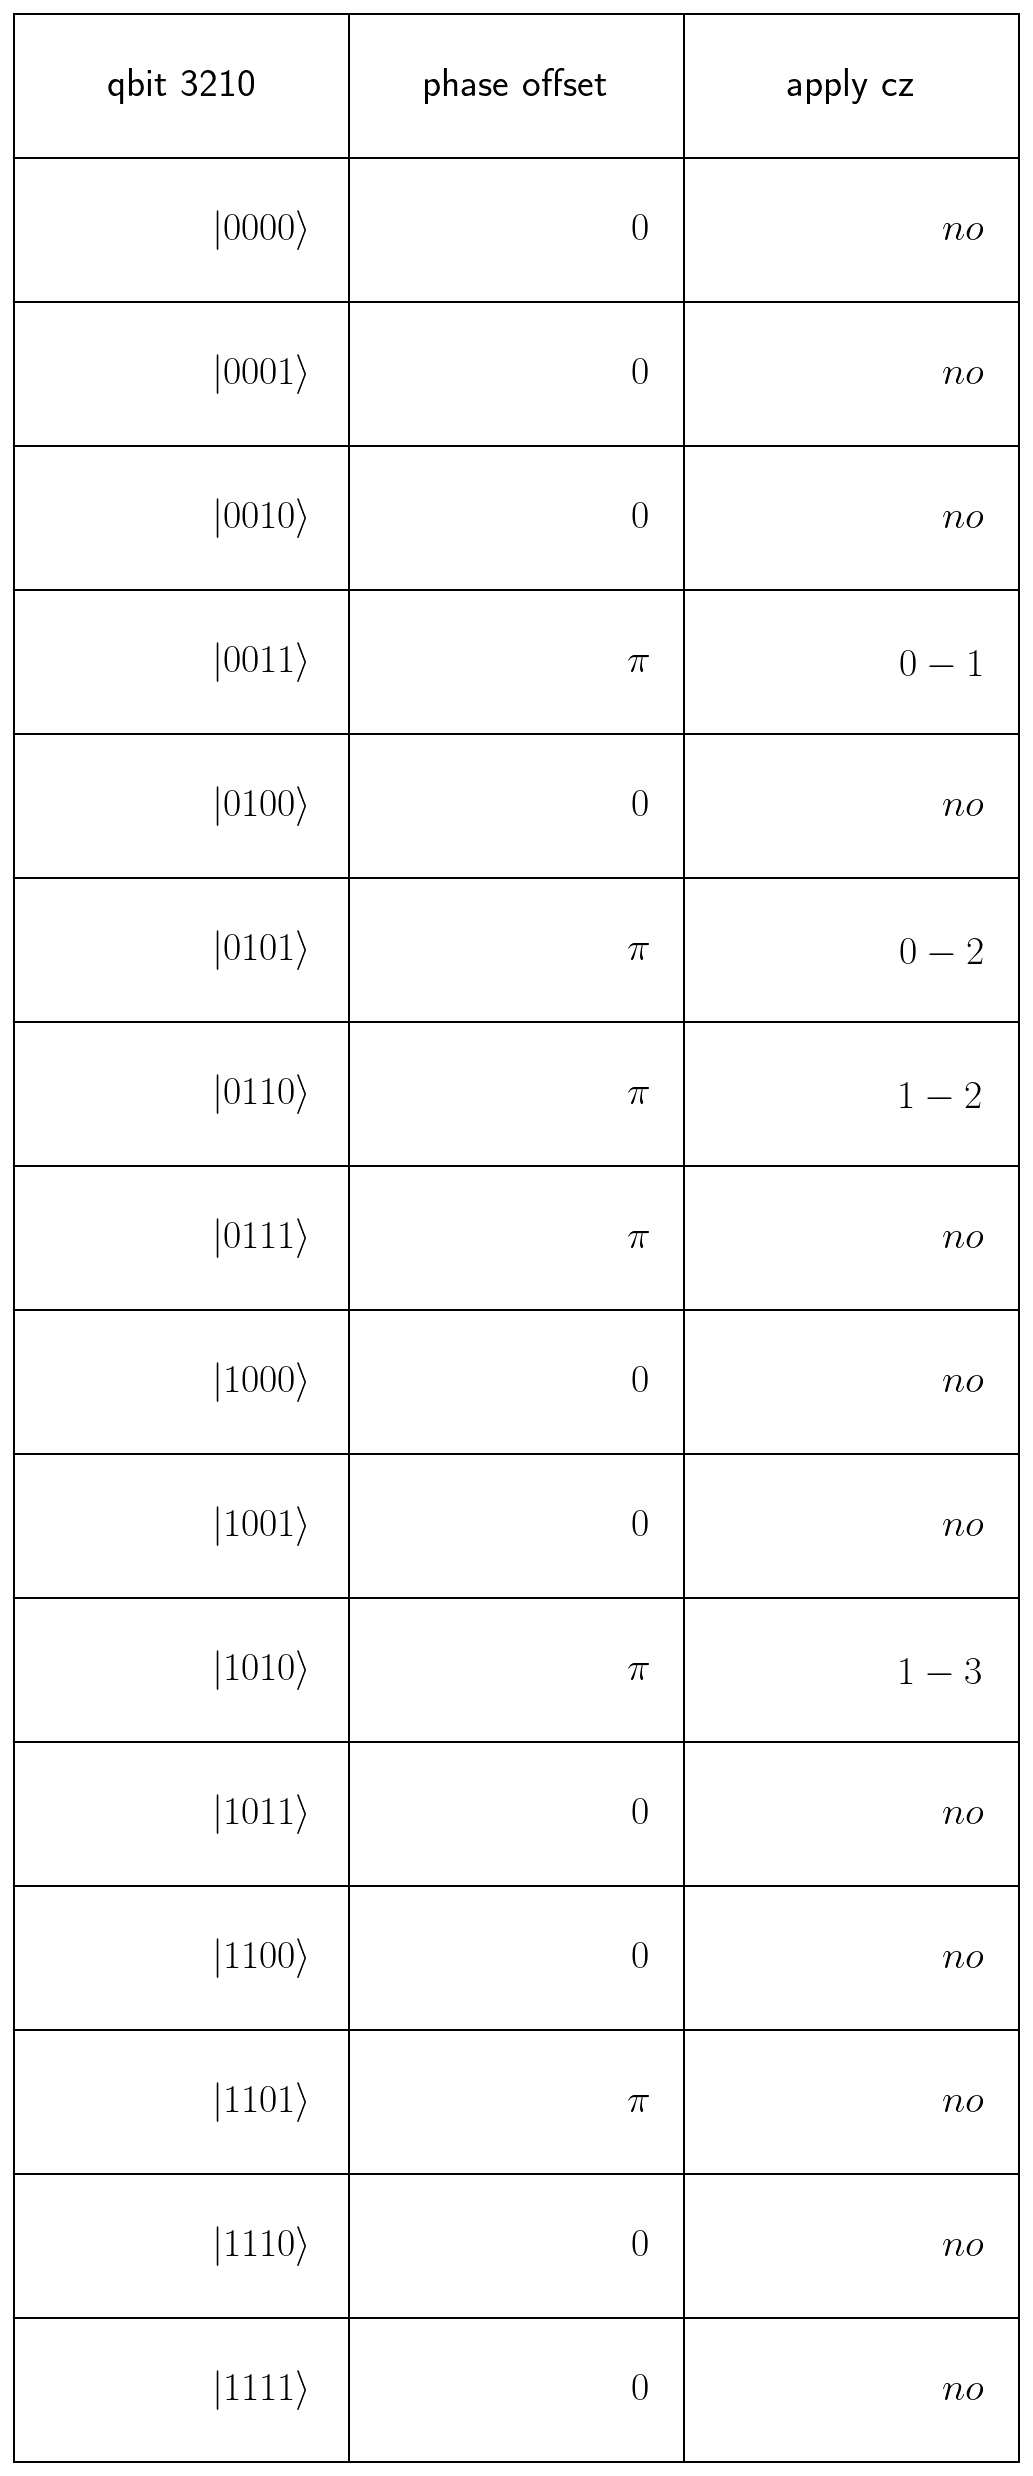

In [163]:
qbits_needing_cz = []
for idx in range(len(phase_diff)):
    phase = phase_diff[idx]
    if bin(idx).count("1") == 2 and phase == sym.pi:
        bits = []
        for i, c in enumerate(bin(idx)[:1:-1], 0):
            if c == '1':
                bits.append(i)
        qbits_needing_cz.append(bits)
#print(qbits_needing_cz)

table_data = []
for idx, phase in enumerate(phase_diff):
    ketval = idx
    ket_args = [int(x) for x in '{:04b}'.format(ketval)]
    ket_val = Ket(*ket_args)
    ket_val_latex = r"${}$".format(sym.latex(ket_val))
    phase_latex = r"${}$".format(sym.latex(phase))
    result_latex = r"$no$"
    if bin(idx).count("1") == 2 and phase == sym.pi:
        bits = []
        for i, c in enumerate(bin(idx)[:1:-1], 0):
            if c == '1':
                bits.append(i)
        result_latex = r"${} - {}$".format(bits[0], bits[1])
    table_data.append([ket_val_latex, phase_latex, result_latex])

collabel=("qbit 3210", "phase offset", "apply cz")
gen_table(table_data, collabel, figsize=(3,6), font_size=20, table_scale=(3,6))
plt.show()

Note: for state 0111 and 1101 we are not applying a cz gate. This is because another cz gate is taking care of applying the phase shift.  
0111 should be 0-1-2 but we already have a cz gate across 0-1 and 0-2.  
1101 should be 0-2-3 but we already have a cz gate across 0-2.

We can create the following circuit from the above table.  
We're adding some barriers to better see how the circuits looks like when we print it

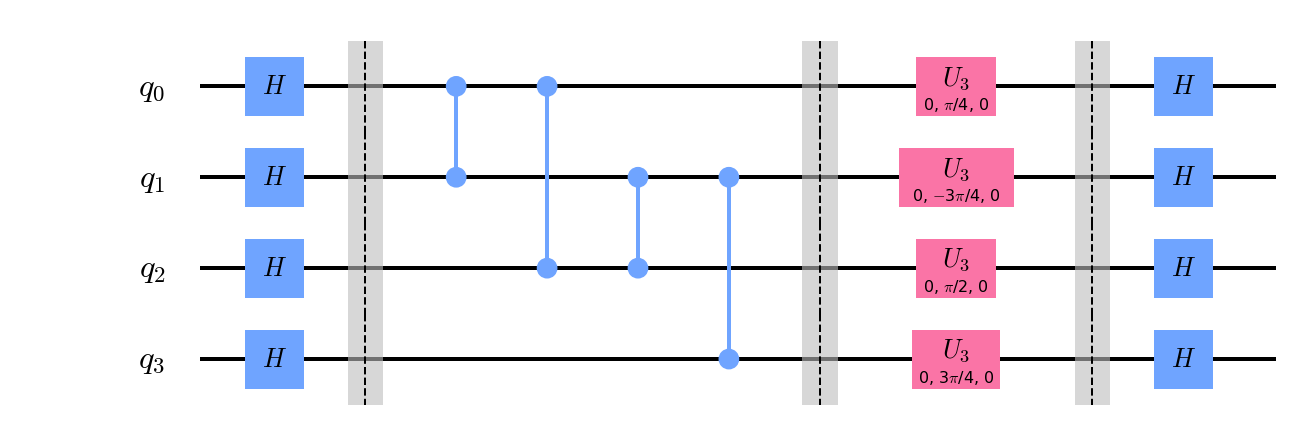

In [188]:
def optimized4():
    qc = QuantumCircuit(num_qbit)
    qc.h(num_qbit_list)
    qc.barrier()
    for qbits in qbits_needing_cz:
        qc.cz(qbits[0], qbits[1])
    qc.barrier()
    for i in range(num_qbit):
        qc.u3(0,single_qbit_shift[i],0,i)
    qc.barrier()
    qc.h(num_qbit_list)
    return qc

qc = optimized4()
qc.draw(output='mpl')

We can try to remove the barriers, feed it to the transpiler and check our score!

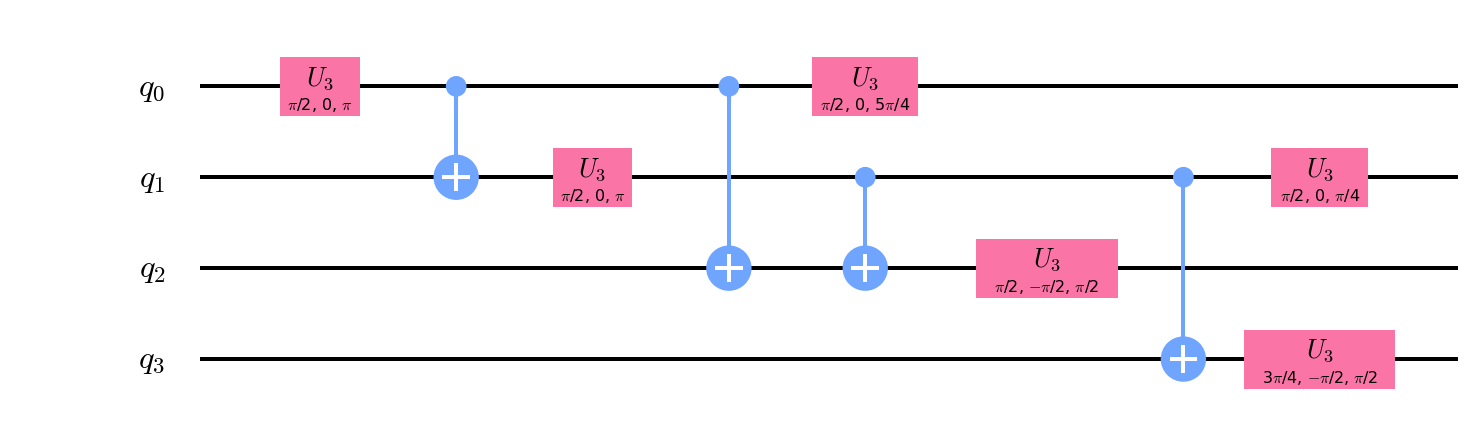

In [227]:
def optimized5():
    qc = QuantumCircuit(num_qbit)
    qc.h(num_qbit_list)
    for qbits in qbits_needing_cz:
        qc.cz(qbits[0], qbits[1])
    for i in range(num_qbit):
        qc.u3(0,single_qbit_shift[i],0,i)
    qc.h(num_qbit_list)
    qc_t = transpile(qc, basis_gates = ['u3', 'cx'], optimization_level=3)
    
    return qc_t

qc = optimized5()
qc.draw(output='mpl')

In [228]:
check_circuit(qc)

Circuit stats:
||U-V||_2 = 1.4545997371336805e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 46

Great! Your circuit meets all the constrains.
Your score is 46. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


Well Done! How does this compare to the solution Elisa Bäumer presented in the youtube live stream https://www.youtube.com/watch?v=3oNXkCZ9odQ which took part after the challenge?  
(you can find the notes here)
Let's take a look:

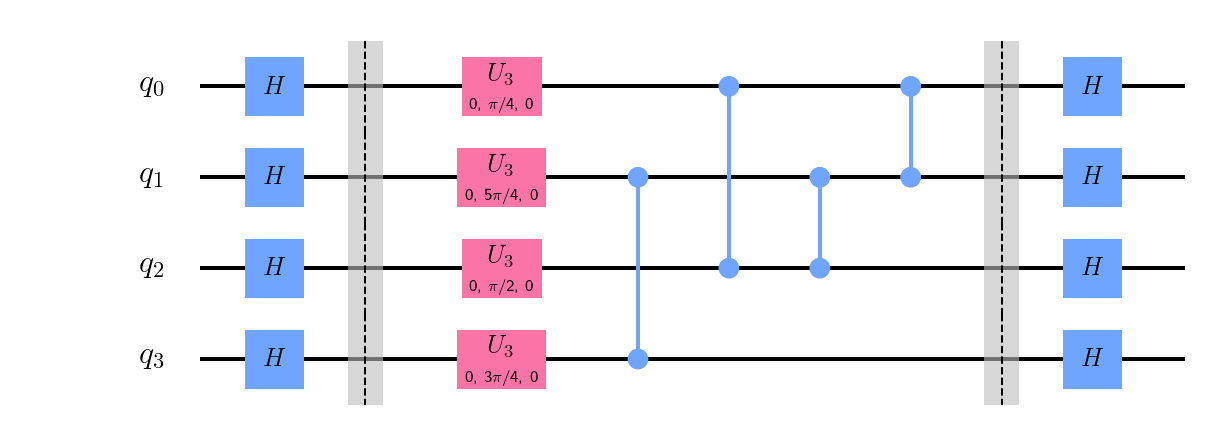

In [164]:
def optimized6():
    qc = QuantumCircuit(4)
    qc.h(num_qbit_list)
    qc.barrier()
    qc.u3(0,np.pi/4,0,0)
    qc.u3(0,5*np.pi/4,0,1)
    qc.u3(0,2*np.pi/4,0,2)
    qc.u3(0,3*np.pi/4,0,3)
    qc.cz(1, 3)
    qc.cz(0, 2)
    qc.cz(1, 2)
    qc.cz(0, 1)
    qc.barrier()
    qc.h(num_qbit_list)

    return qc

qc = optimized6()
qc_opt6 = qc
qc.draw(output='mpl')

If you notice it's exactly the same:  
She just have the U gates in front of the cz gates which in turn are in slightly different order.  
How about coefficients of the U3 gates? They're the same!  
You don't believe me? good...

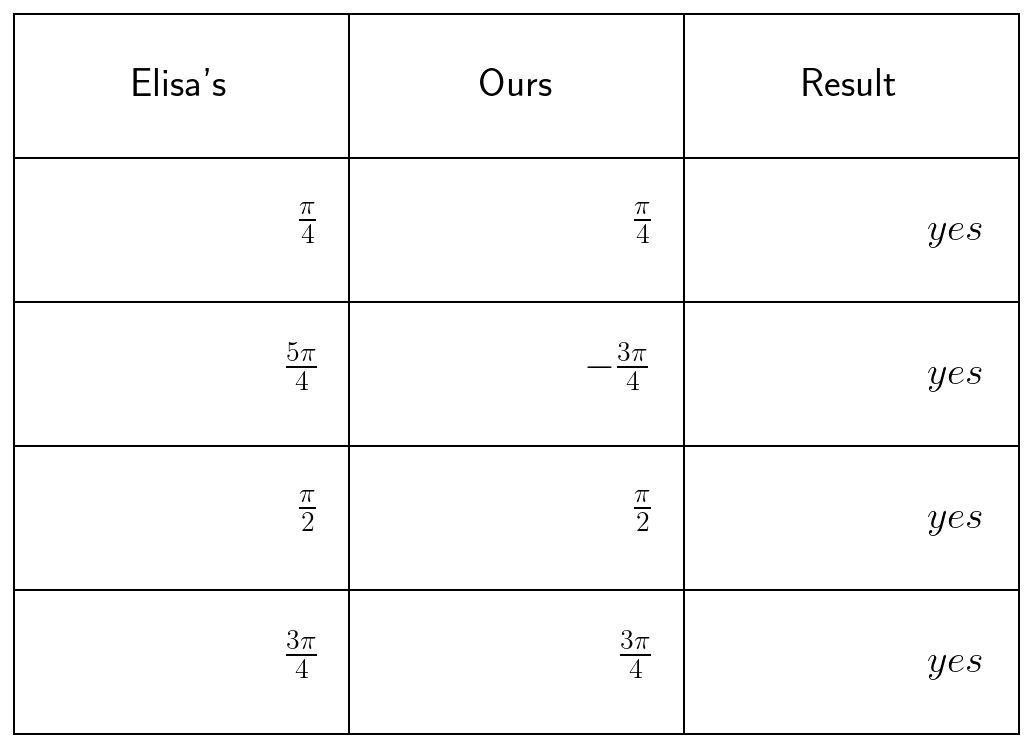

In [165]:
elisa_u3_coeff = [sym.pi/4, 5*sym.pi/4, 2*sym.pi/4, 3*sym.pi/4]
single_qbit_shift_sym = vnsimplify(single_qbit_shift, constants=[sym.sqrt(2), sym.pi])
table_data = []

def rad_angles_are_equal(a1, a2):
    return sym.sin(a1) == sym.sin(a2) and sym.cos(a1) == sym.cos(a2)

for idx, shift in enumerate(single_qbit_shift_sym):
    res = rad_angles_are_equal(shift, elisa_u3_coeff[idx])
    col1 = r"${}$".format(sym.latex(elisa_u3_coeff[idx]))
    col2 = r"${}$".format(sym.latex(shift))
    col3 = r"${}$".format("yes" if res else "no")
    table_data.append([col1, col2, col3])

collabel=("Elisa's", "Ours", "Result")
gen_table(table_data, collabel, figsize=(3,6), font_size=20, table_scale=(3,6))
plt.show()

Notice how even though I specified `qc.u3(0,2*np.pi/4,0,2)` for qbit `q2` the circuit drawing simplified it by its own into $\pi/2$

Well done!  
Another approach which allowed Luciano Pereira Valenzuela to achieve the lowest found score of 45 is the following.  
In his words from the #ibm-quantum-challenge slack channel:  
> I multiplied gates to U in order to obtain the identity.
I did this per qubit, that's, first I transformed U to I kron V,
and then I repeat per qubit. Finally, 
I reduce the circuit size combining u3 gates and employing a c-not identity.

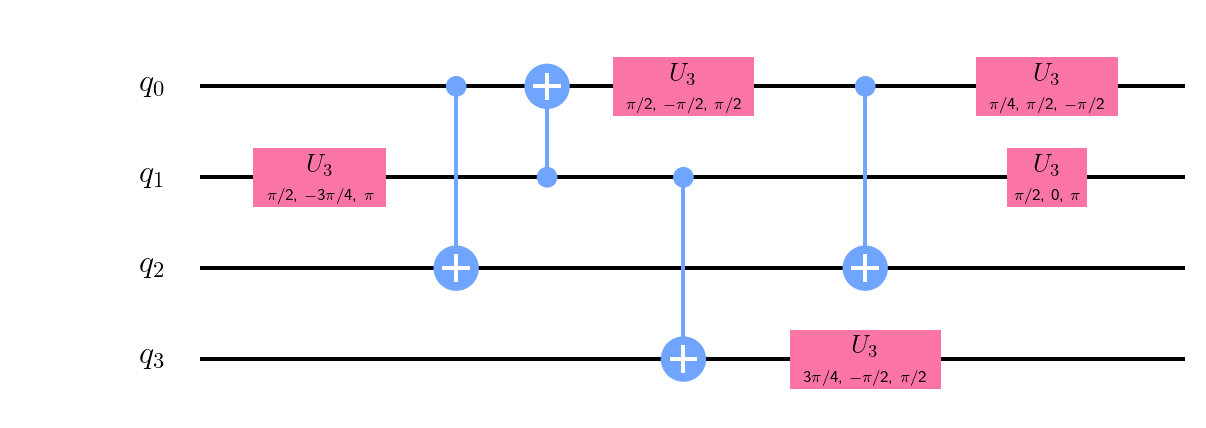

In [8]:
def optimized7():
    qc = QuantumCircuit(4)
    qc.u3(np.pi/2,-3*np.pi/4,np.pi,1)
    qc.cx(0, 2)
    qc.cx(1, 0)
    qc.u3(np.pi/2,-np.pi/2,np.pi/2,0)
    qc.cx(1, 3)
    qc.cx(0, 2)
    qc.u3(3*np.pi/4,-np.pi/2,np.pi/2,3)
    qc.u3(np.pi/4,np.pi/2,-np.pi/2,0)
    qc.u3(np.pi/2,0,np.pi,1)
    qc_t = transpile(qc, basis_gates = ['u3', 'cx'], optimization_level=3)

    return qc_t

qc = optimized7()
qc.draw(output='mpl')

In [161]:
check_circuit(qc)

Circuit stats:
||U-V||_2 = 1.3705158712462245e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 45

Great! Your circuit meets all the constrains.
Your score is 45. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


What can we say? Amazing!  
Let's try and apply what was shown into the above youtube video to get from our circuit scoring 46 to this other one.  
In order to understand this, we have to introduce the concept of gate identities. Simply put, gates can be rewritten in another form or cancel each other out under certain conditions.  
In the following snippets I'm going to draw and prove you the identities we're going to use.  
### Identity 1:

Does circuit A matrix equals circuit B matrix? yes


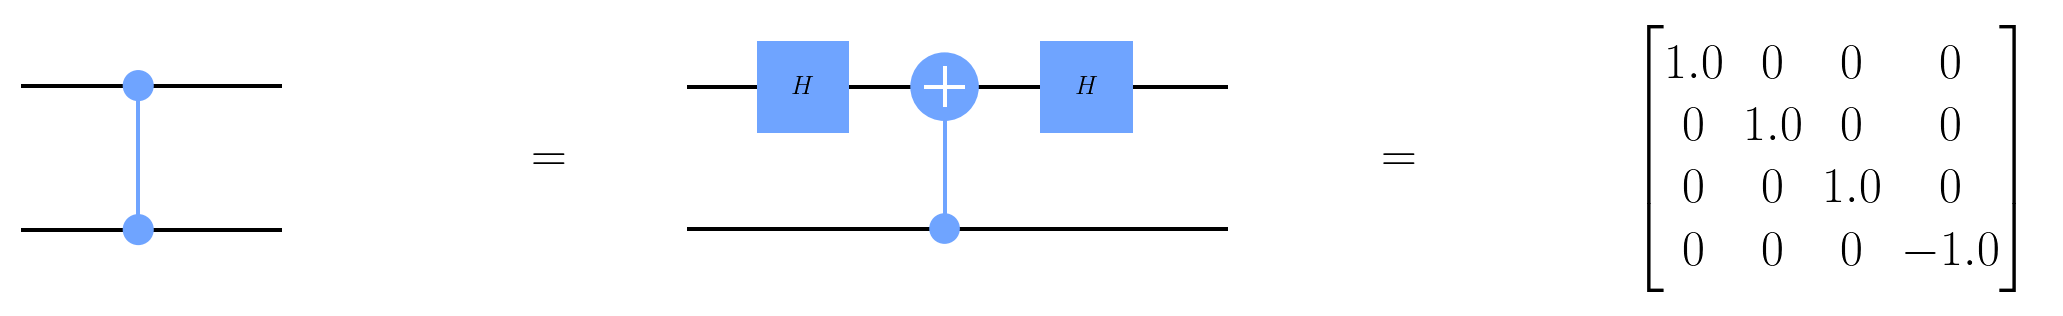

In [415]:
def get_qc_id1_a():
    qc = QuantumCircuit(2)
    qc.cz(0, 1)
    return qc

def get_qc_id1_b():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(1, 0)
    qc.h(0)
    return qc

qc_id1_a = get_qc_id1_a()
qc_id1_b = get_qc_id1_b()

prove_circuit_identity(qc_id1_a, qc_id1_b, circuit_margin=[0, 0, 0, 0])

plt.show()

### Identity 2:

Does circuit A matrix equals circuit B matrix? yes


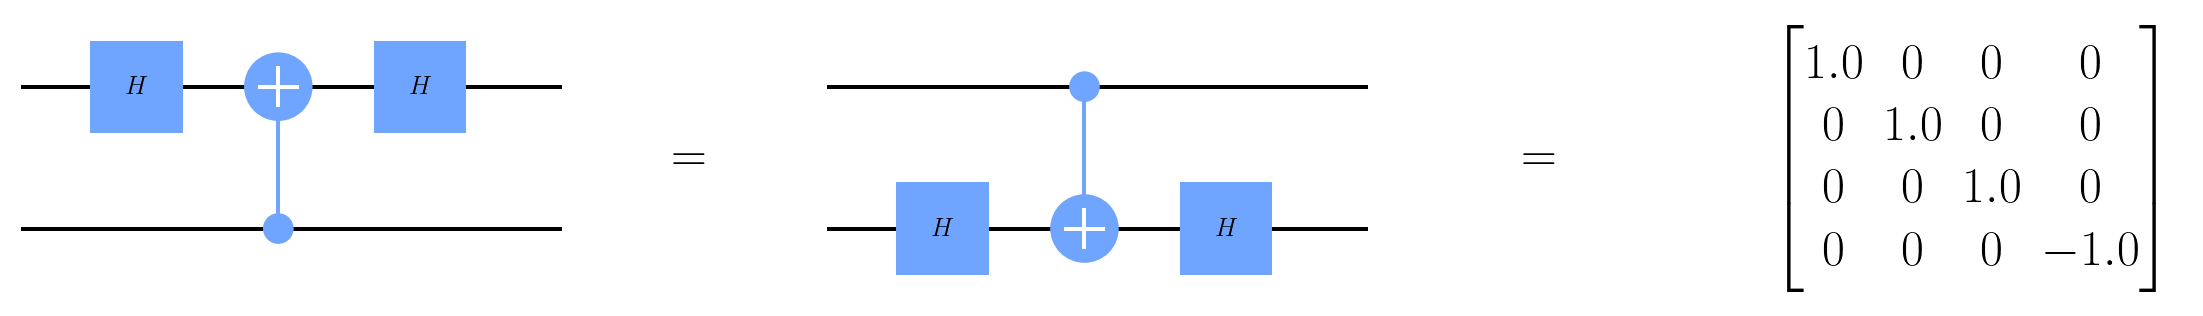

In [414]:
def get_qc_id2_a():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(1, 0)
    qc.h(0)
    return qc

def get_qc_id2_b():
    qc = QuantumCircuit(2)
    qc.h(1)
    qc.cx(0, 1)
    qc.h(1)
    return qc

qc_id2_a = get_qc_id2_a()
qc_id2_b = get_qc_id2_b()

prove_circuit_identity(qc_id2_a, qc_id2_b, circuit_margin=[0, 0, 0, 0])

plt.show()

### Identity 3:

Does circuit A matrix equals circuit B matrix? yes


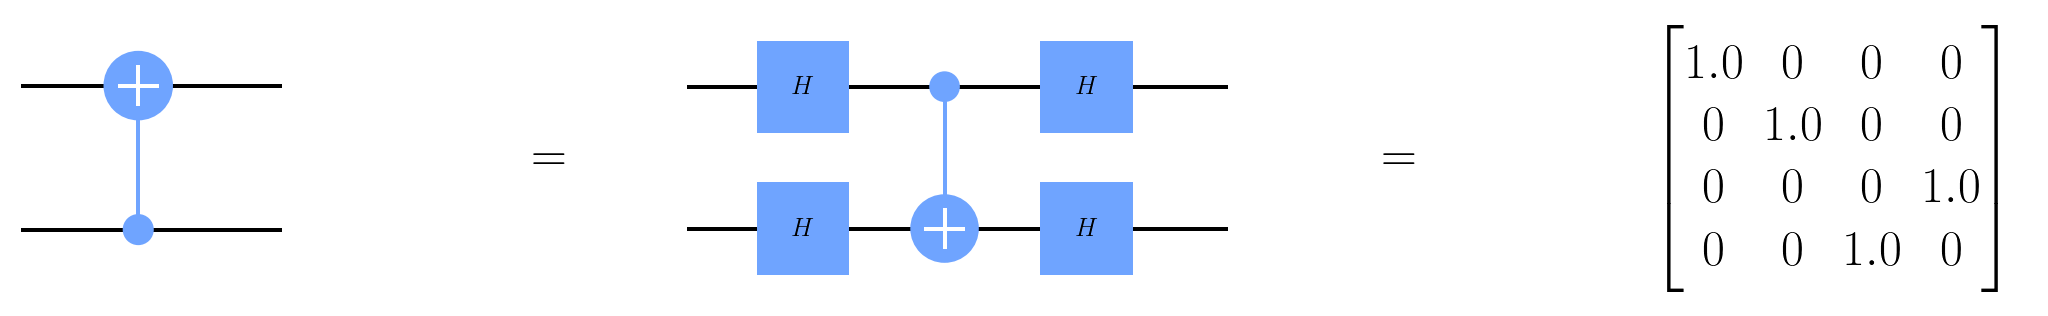

In [413]:
def get_qc_id3_a():
    qc = QuantumCircuit(2)
    qc.cx(1, 0)
    return qc

def get_qc_id3_b():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.h(1)
    qc.cx(0, 1)
    qc.h(0)
    qc.h(1)
    return qc

qc_id3_a = get_qc_id3_a()
qc_id3_b = get_qc_id3_b()

prove_circuit_identity(qc_id3_a, qc_id3_b, circuit_margin=[0, 0, 0, 0])

plt.show()

### Identity 4:

Does circuit A matrix equals circuit B matrix? yes


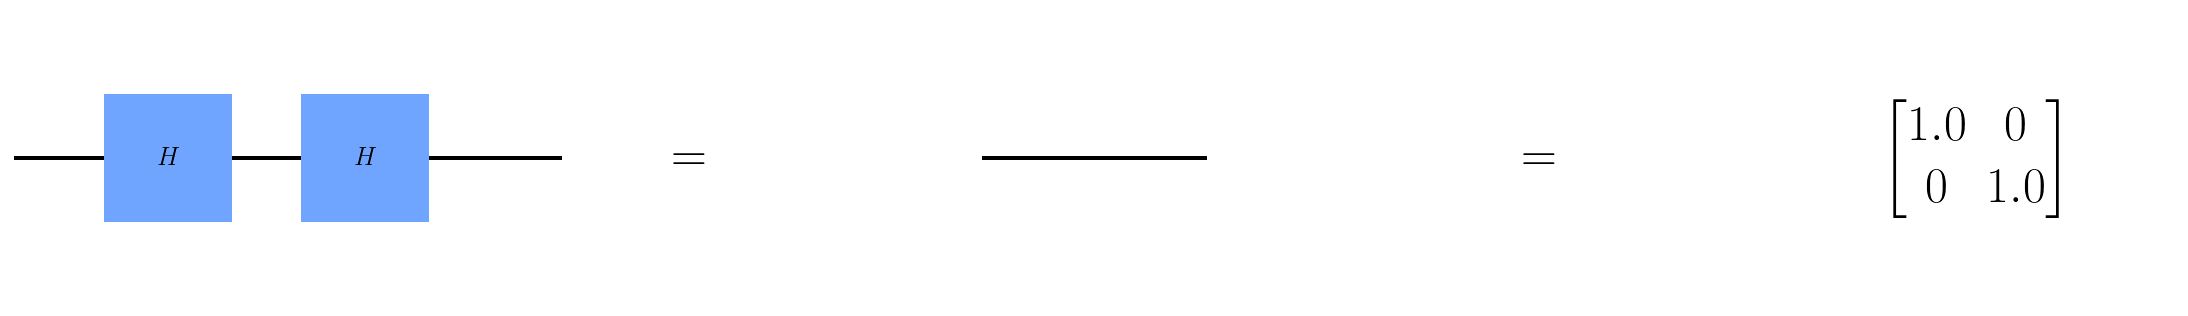

In [412]:
def get_qc_id4_a():
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.h(0)
    return qc

def get_qc_id4_b():
    qc = QuantumCircuit(1)
    return qc

qc_id4_a = get_qc_id4_a()
qc_id4_b = get_qc_id4_b()

prove_circuit_identity(qc_id4_a, qc_id4_b, circuit_margin=[1, 0, 0, 0])

plt.show()

### Identity 5:

Does circuit A matrix equals circuit B matrix? yes


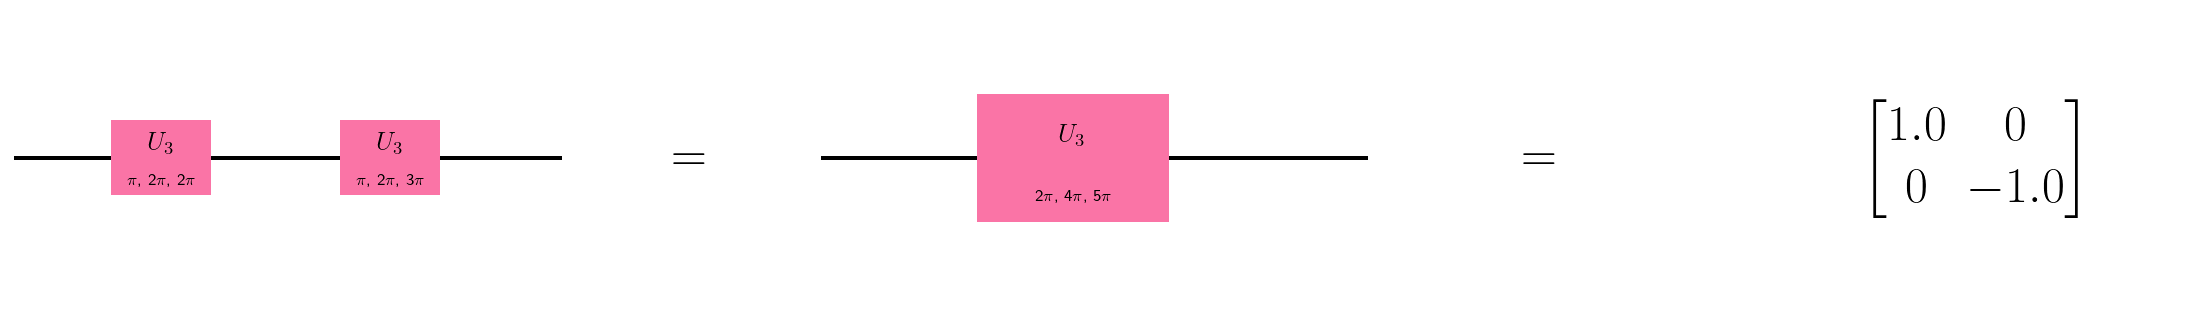

In [411]:
id5_qc1_1 = 1
id5_qc1_2 = 2
id5_qc1_3 = 2
id5_qc2_1 = 1
id5_qc2_2 = 2
id5_qc2_3 = 3

def get_qc_id5_a():
    qc = QuantumCircuit(1)
    qc.u3(id5_qc1_1*np.pi,id5_qc1_2*np.pi,id5_qc1_3*np.pi,0)
    qc.u3(id5_qc2_1*np.pi,id5_qc2_2*np.pi,id5_qc2_3*np.pi,0)
    return qc

def get_qc_id5_b():
    qc = QuantumCircuit(1)
    qc.u3((id5_qc1_1+id5_qc2_1)*np.pi,(id5_qc1_2+id5_qc2_2)*np.pi,(id5_qc1_3+id5_qc2_3)*np.pi,0)
    return qc

qc_id5_a = get_qc_id5_a()
qc_id5_b = get_qc_id5_b()

prove_circuit_identity(qc_id5_a, qc_id5_b, circuit_margin=[1, 0, 0, 0])

plt.show()

### Identity 6:

Does circuit A matrix equals circuit B matrix? yes


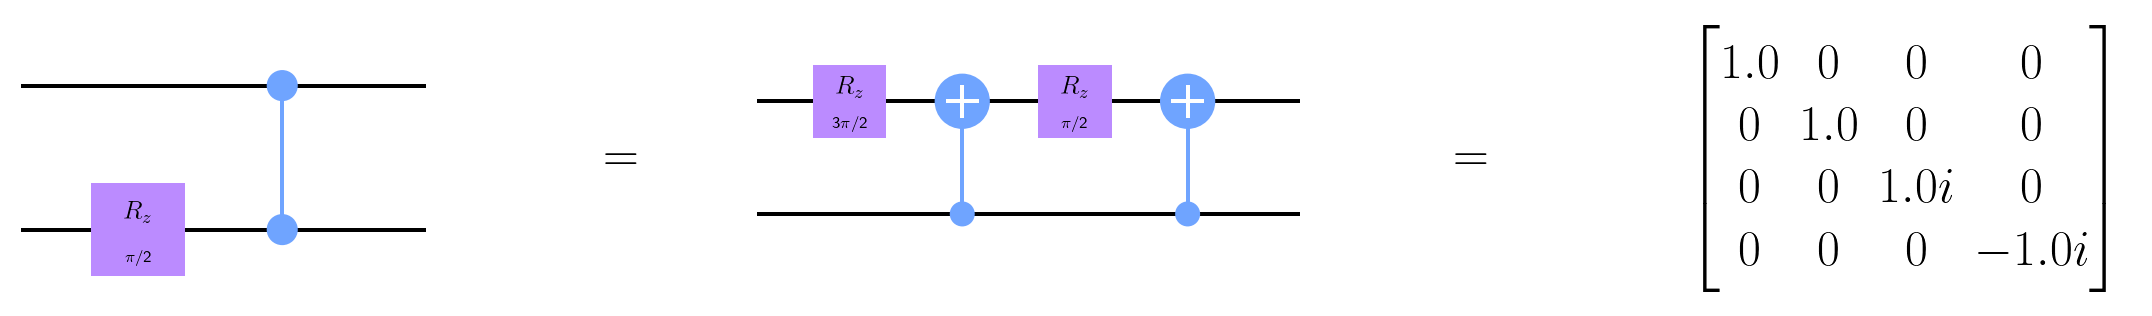

In [410]:
def get_qc_id6_a():
    qc = QuantumCircuit(2)
    qc.rz(np.pi/2, 1)
    qc.cz(0, 1)
    return qc

def get_qc_id6_b():
    qc = QuantumCircuit(2)
    qc.rz(3*np.pi/2, 0)
    qc.cx(1, 0)
    qc.rz(np.pi/2, 0)
    qc.cx(1, 0)
    return qc

qc_id6_a = get_qc_id6_a()
qc_id6_b = get_qc_id6_b()

prove_circuit_identity(qc_id6_a, qc_id6_b, circuit_margin=[0, 0, 0, 0])

plt.show()

### Identity 7:

Does circuit A matrix equals circuit B matrix? yes


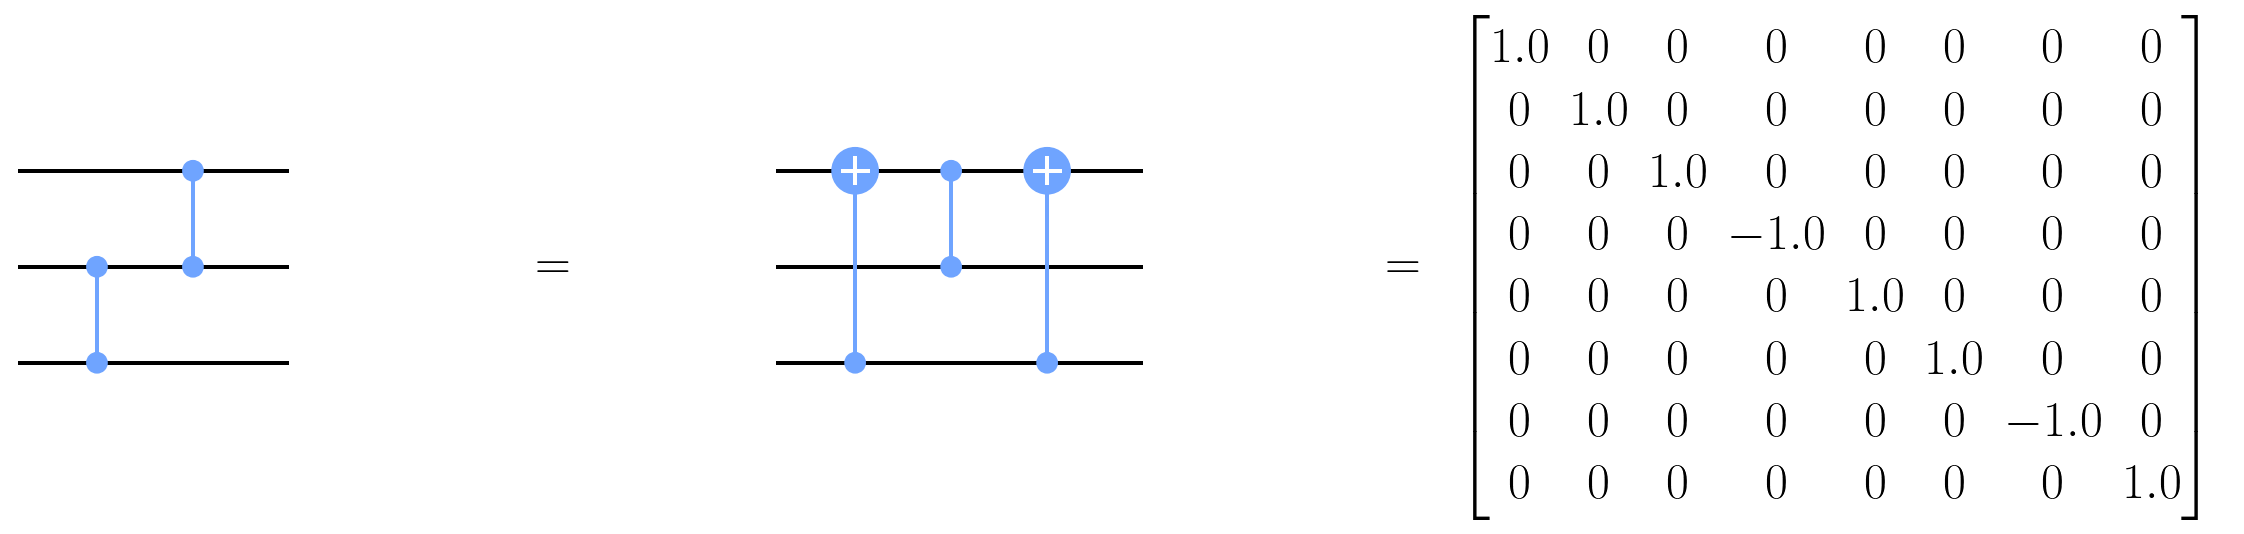

In [408]:
def get_qc_id7_a():
    qc = QuantumCircuit(3)
    qc.cz(1, 2)
    qc.cz(0, 1)
    return qc

def get_qc_id7_b():
    qc = QuantumCircuit(3)
    qc.cx(2, 0)
    qc.cz(0, 1)
    qc.cx(2, 0)
    return qc

qc_id7_a = get_qc_id7_a()
qc_id7_b = get_qc_id7_b()

prove_circuit_identity(qc_id7_a, qc_id7_b, circuit_margin=[0, 0, 0, 0])

plt.show()

### Identity 8:

Does circuit A matrix equals circuit B matrix? yes


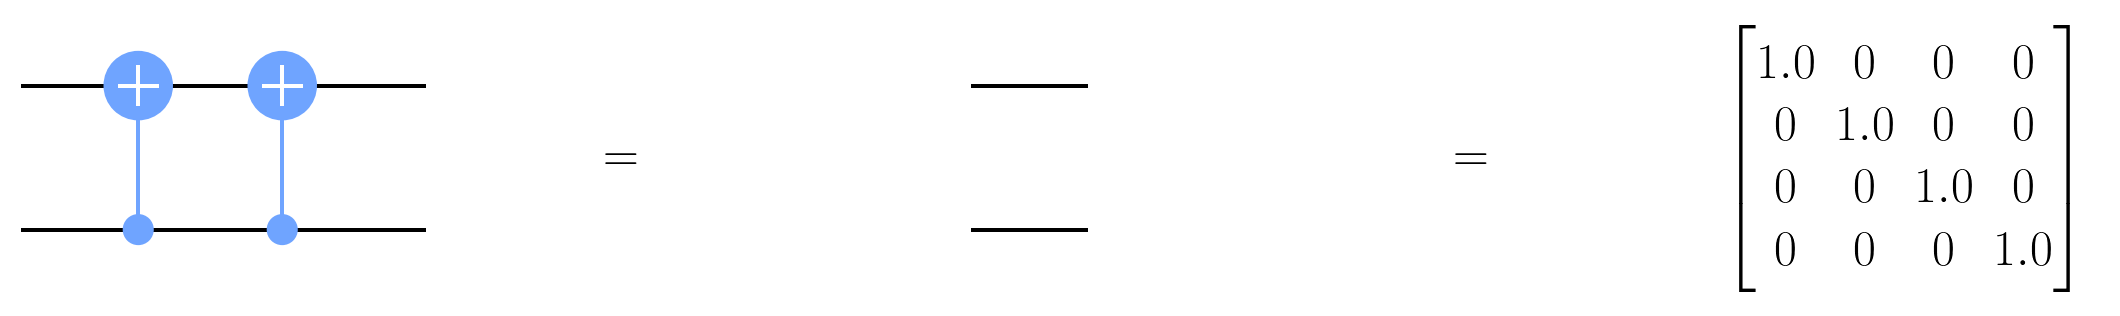

In [407]:
def get_qc_id8_a():
    qc = QuantumCircuit(2)
    qc.cx(1, 0)
    qc.cx(1, 0)
    return qc

def get_qc_id8_b():
    qc = QuantumCircuit(2)
    return qc

qc_id8_a = get_qc_id8_a()
qc_id8_b = get_qc_id8_b()

prove_circuit_identity(qc_id8_a, qc_id8_b, circuit_margin=[0, 0, 0, 0])

plt.show()

### Identity 9:

Does circuit A matrix equals circuit B matrix? no
Does circuit A matrix equals circuit B matrix? yes


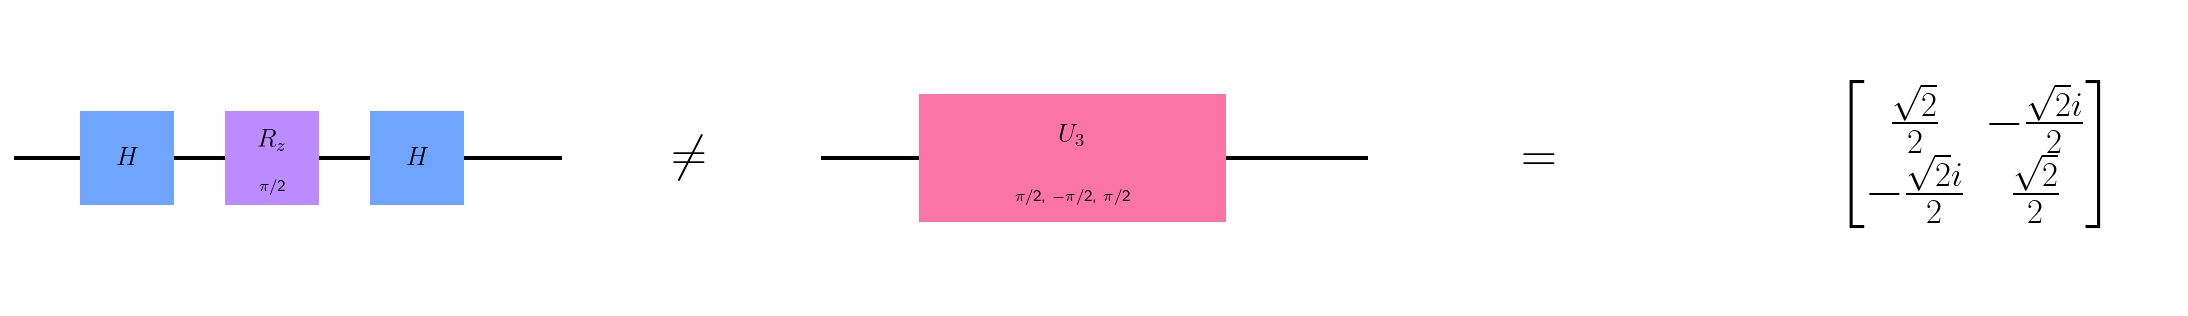

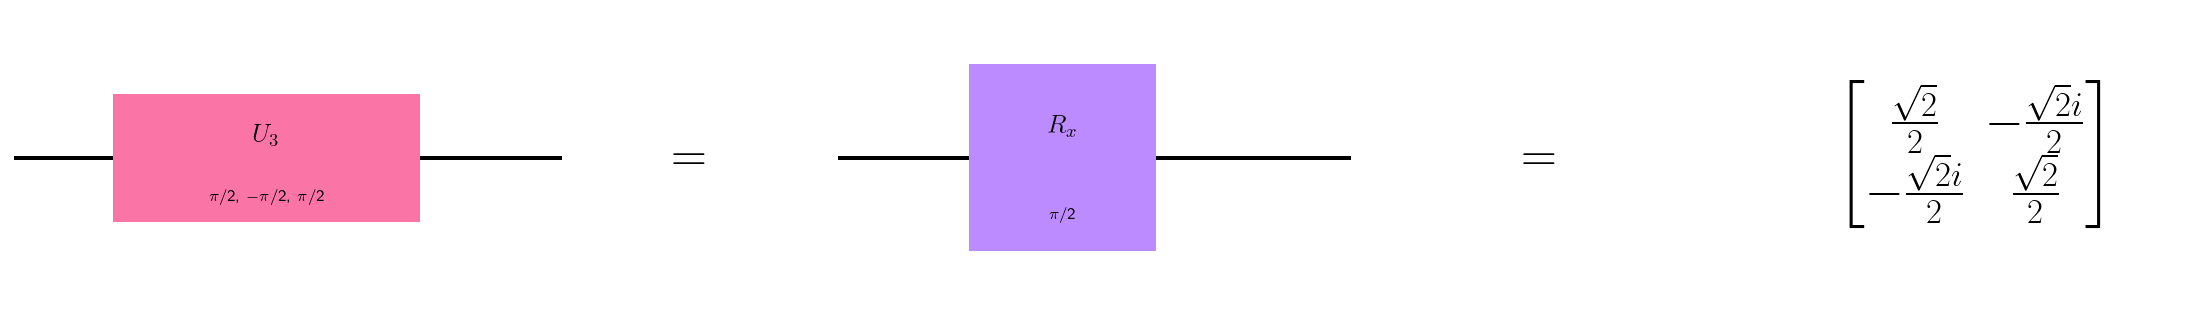

In [685]:
def get_qc_id9_a():
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.rz(np.pi/2,0)
    qc.h(0)
    return qc

def get_qc_id9_b():
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.rz(np.pi/2,0)
    qc.h(0)
    qc = transpile(qc, basis_gates = ['u3'], optimization_level=3)
    return qc

def get_qc_id9_c():
    qc = QuantumCircuit(1)
    qc.rx(2*np.pi/4,0)
    return qc

qc_id9_a = get_qc_id9_a()
qc_id9_b = get_qc_id9_b()
qc_id9_c = get_qc_id9_c()

prove_circuit_identity(qc_id9_a, qc_id9_b, circuit_margin=[1, 0, 0, 0], constants=[sym.sqrt(2), sym.pi], tolerance=0.001)
prove_circuit_identity(qc_id9_b, qc_id9_c, circuit_margin=[1, 0, 0, 0], constants=[sym.sqrt(2), sym.pi], tolerance=0.001)

plt.show()

So what's going on here? Why the transpiler transpile to a different matrix?  
Let's try and print the 3 circuit unitary

In [569]:
qc_id9_a_unitary = get_circuit_matrix(qc_id9_a)
qc_id9_a_unitary_sym = to_sympy_matrix(qc_id9_a_unitary, constants=[sym.sqrt(2), sym.pi], tolerance=0.001)
display(sym.Matrix(qc_id9_a_unitary_sym))

qc_id9_b_unitary = get_circuit_matrix(qc_id9_b)
qc_id9_b_unitary_sym = to_sympy_matrix(qc_id9_b_unitary, constants=[sym.sqrt(2), sym.pi], tolerance=0.001)
display(sym.Matrix(qc_id9_b_unitary_sym))

qc_id9_c_unitary = get_circuit_matrix(qc_id9_c)
qc_id9_c_unitary_sym = to_sympy_matrix(qc_id9_c_unitary, constants=[sym.sqrt(2), sym.pi], tolerance=0.001)
display(sym.Matrix(qc_id9_c_unitary_sym))

⎡1   ⅈ  1   ⅈ⎤
⎢─ + ─  ─ - ─⎥
⎢2   2  2   2⎥
⎢            ⎥
⎢1   ⅈ  1   ⅈ⎥
⎢─ - ─  ─ + ─⎥
⎣2   2  2   2⎦

⎡  √2    -√2⋅ⅈ ⎤
⎢  ──    ──────⎥
⎢  2       2   ⎥
⎢              ⎥
⎢-√2⋅ⅈ     √2  ⎥
⎢──────    ──  ⎥
⎣  2       2   ⎦

⎡  √2    -√2⋅ⅈ ⎤
⎢  ──    ──────⎥
⎢  2       2   ⎥
⎢              ⎥
⎢-√2⋅ⅈ     √2  ⎥
⎢──────    ──  ⎥
⎣  2       2   ⎦

As you can see B and C are the same so this should be enough to let you trust me.  
Let's focus on why A got transpiled to B

In [554]:
qc_id9_dem_res = qc_id9_b_unitary / qc_id9_a_unitary
qc_id9_dem_res_sym = to_sympy_matrix(qc_id9_dem_res, constants=[sym.sqrt(2), sym.pi], tolerance=0.001)
qc_id9_dem_res_polar_sym = v_to_polar_exp(qc_id9_dem_res, constants=[sym.sqrt(2), sym.pi], tolerance=0.001)
display(sym.Matrix(qc_id9_dem_res_sym))
display(sym.Matrix(qc_id9_dem_res_polar_sym))

⎡√2⋅(1 - ⅈ)  √2⋅(1 - ⅈ)⎤
⎢──────────  ──────────⎥
⎢    2           2     ⎥
⎢                      ⎥
⎢√2⋅(1 - ⅈ)  √2⋅(1 - ⅈ)⎥
⎢──────────  ──────────⎥
⎣    2           2     ⎦

⎡   -π      -π ⎤
⎢ ⅈ⋅───   ⅈ⋅───⎥
⎢    4       4 ⎥
⎢ℯ       ℯ     ⎥
⎢              ⎥
⎢   -π      -π ⎥
⎢ ⅈ⋅───   ⅈ⋅───⎥
⎢    4       4 ⎥
⎣ℯ       ℯ     ⎦

As you can see every matrix term is divisible by the same coefficient.  
This mean we can "simplify" the circuit by dividing the whole matrix by it  

A special thanks goes to Aditya Giridharan which helped me demonstrating this. As he puts it:
> the basic idea is that if you take a quantum state and multiply it throughout by a complex number, it doesn't change the probabilities of measuring 0 or 1 and so it is indistinguishable from the original state - this is called a global phase factor and for most practical purposes it is ignored

I have updated our `prove_circuit_identity` function to allow us to ignore the phase with a slightly more complex logic inspired (stolen) from the source code of the challenge in charge of checking the circuit before submitting.  
Let's try then to compare the two circuits by ignoring the global phase

Does circuit A matrix equals circuit B matrix? yes


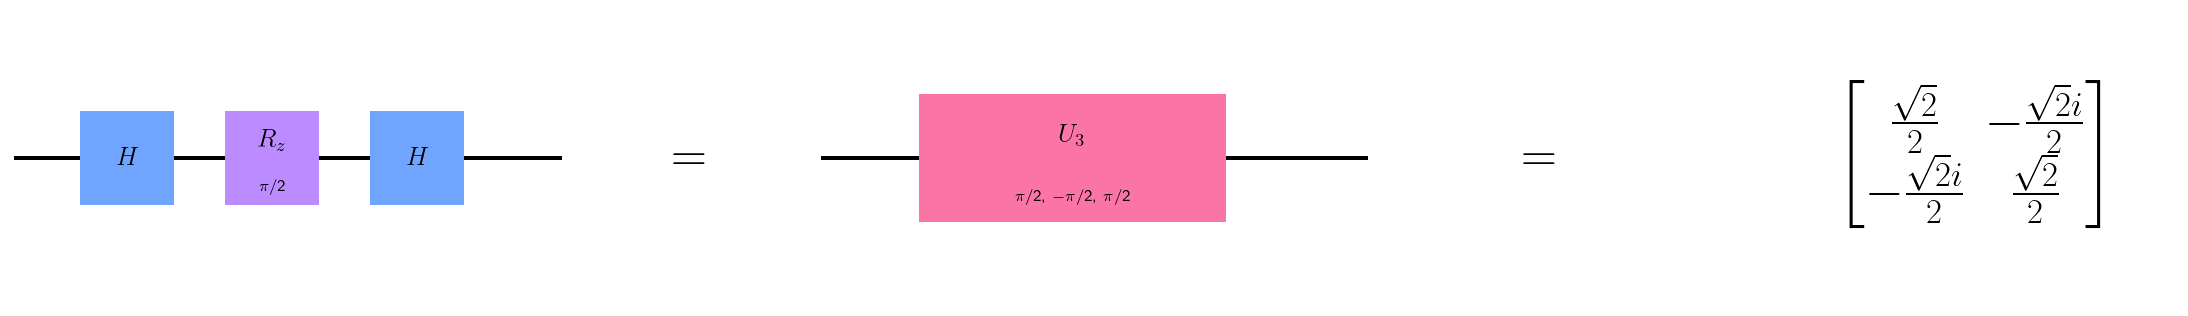

In [686]:
prove_circuit_identity(qc_id9_a, qc_id9_b, circuit_margin=[1, 0, 0, 0], constants=[sym.sqrt(2), sym.pi], tolerance=0.001, ignore_global_phase=True)

So now we can take the circuit where we achieved our score of 46 and applying identities 1 and 2 we get the following result.  
As pointed out in the video, it looks like a more complex (costly) circuit but we're going to apply more identities to simplify it further.  
Note: ```qc.u3(0,np.pi/4,0,0)``` = ```qc.rz(np.pi/4,0)```

Does circuit A matrix equals circuit B matrix? yes


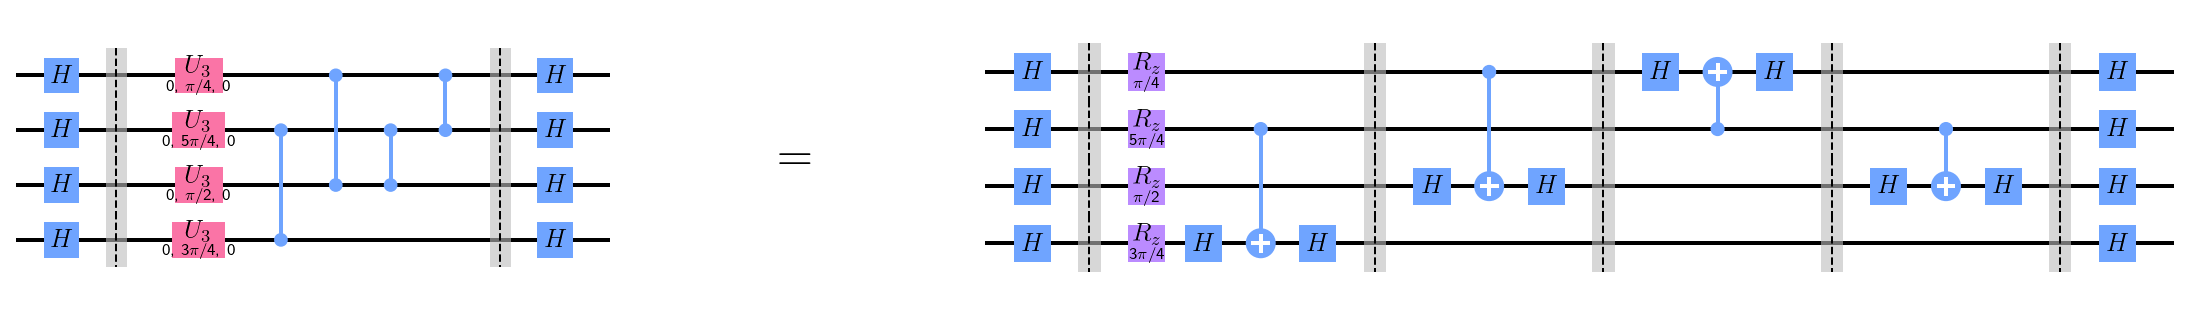

In [406]:
def optimized8():
    qc = QuantumCircuit(4)
    qc.h(num_qbit_list)
    qc.barrier()
    qc.rz(np.pi/4,0)
    qc.rz(5*np.pi/4,1)
    qc.rz(2*np.pi/4,2)
    qc.rz(3*np.pi/4,3)
    qc.h(3)
    qc.cx(1, 3)
    qc.h(3)
    qc.barrier()
    qc.h(2)
    qc.cx(0, 2)
    qc.h(2)
    qc.barrier()
    qc.h(0)
    qc.cx(1, 0)
    qc.h(0)
    qc.barrier()
    qc.h(2)
    qc.cx(1, 2)
    qc.h(2)
    qc.barrier()
    qc.h(num_qbit_list)

    return qc

qc_opt8 = optimized8()

prove_circuit_identity(qc_opt6, qc_opt8, circuit_margin=[0, 0, 0, 0], draw_matrix=False, grid_width_ratios=[5, 1, 10])

plt.show()

By applying identity 5 on qbit 0 and 1 we get

Does circuit A matrix equals circuit B matrix? yes
Does circuit A matrix equals circuit B matrix? yes


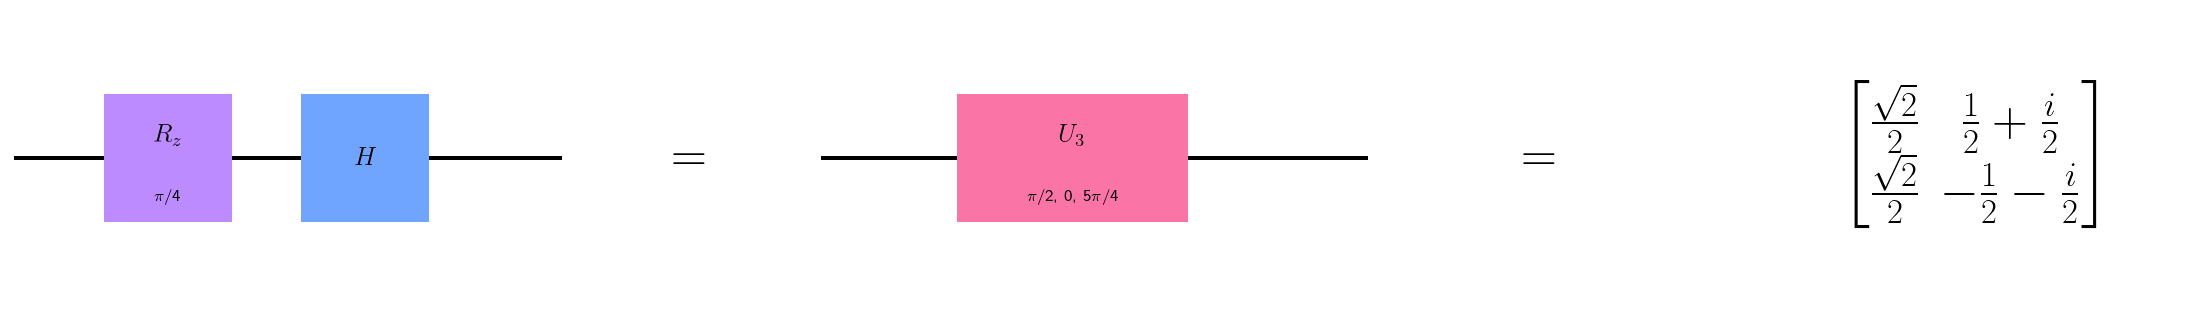

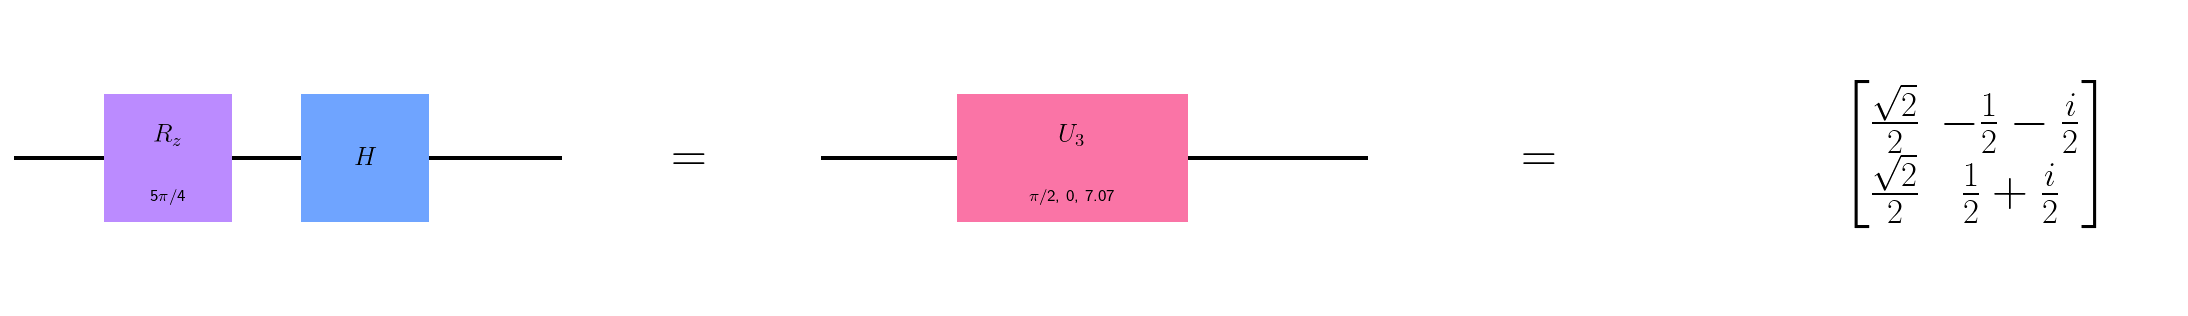

In [573]:
def qbit0_unopt():
    qc = QuantumCircuit(1)
    qc.rz(np.pi/4,0)
    qc.h(0)
    return qc

def qbit0_opt():
    qc = QuantumCircuit(1)
    qc.rz(np.pi/4,0)
    qc.h(0)
    qc_t = transpile(qc, basis_gates = ['u3'], optimization_level=3)
    return qc_t

def qbit1_unopt():
    qc = QuantumCircuit(1)
    qc.rz(5*np.pi/4,0)
    qc.h(0)
    return qc

def qbit1_opt():
    qc = QuantumCircuit(1)
    qc.rz(5*np.pi/4,0)
    qc.h(0)
    qc_t = transpile(qc, basis_gates = ['u3'], optimization_level=3)
    return qc_t

prove_circuit_identity(qbit0_unopt(), qbit0_opt(), circuit_margin=[1, 0, 0, 0], draw_matrix=True, grid_width_ratios=[5, 1, 5, 1, 5], constants=[sym.sqrt(2), sym.pi], tolerance=0.001)
prove_circuit_identity(qbit1_unopt(), qbit1_opt(), circuit_margin=[1, 0, 0, 0], draw_matrix=True, grid_width_ratios=[5, 1, 5, 1, 5], constants=[sym.sqrt(2), sym.pi], tolerance=0.001)

plt.show()

And applying the above identity with identity 4 we get the following equivalent circuit

Does circuit A matrix equals circuit B matrix? yes


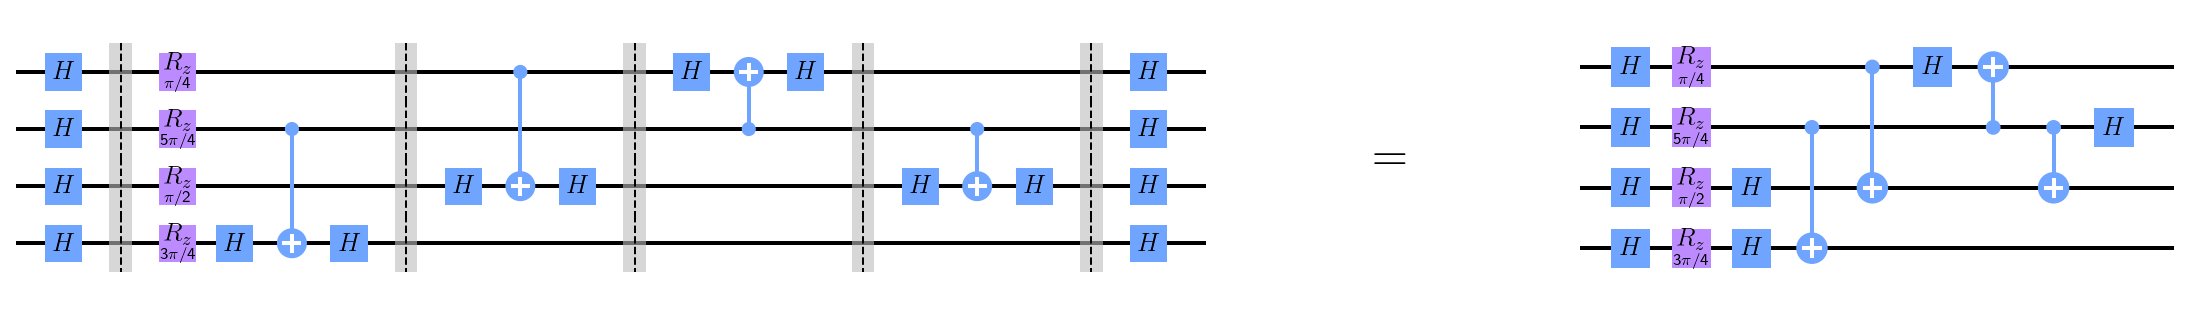

In [607]:
def optimized9():
    qc = QuantumCircuit(4)
    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    qc.rz(np.pi/4,0)
    qc.rz(5*np.pi/4,1)
    qc.rz(2*np.pi/4,2)
    qc.rz(3*np.pi/4,3)
    qc.h(2)
    qc.h(3)
    qc.cx(1, 3)
    qc.cx(0, 2)
    qc.h(0)
    qc.cx(1, 0)
    qc.cx(1, 2)
    qc.h(1)
    
    return qc

qc_opt9 = optimized9()

prove_circuit_identity(qc_opt8, qc_opt9, circuit_margin=[0, 0, 0, 0], draw_matrix=False, grid_width_ratios=[10, 1, 5])

plt.show()

Now for the following bit

Does circuit A matrix equals circuit B matrix? no


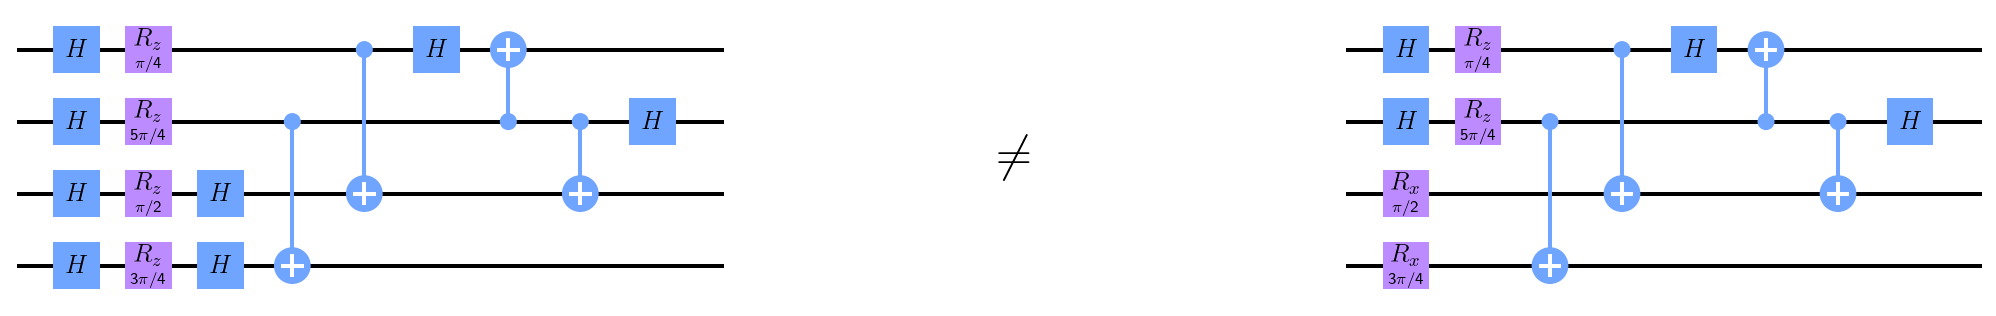

In [689]:
def optimized9_plus():
    qc = QuantumCircuit(4)
    qc.h(0)
    qc.h(1)
    qc.rz(np.pi/4,0)
    qc.rz(5*np.pi/4,1)
    qc.rx(2*np.pi/4,2)
    qc.rx(3*np.pi/4,3)
    qc.cx(1, 3)
    qc.cx(0, 2)
    qc.h(0)
    qc.cx(1, 0)
    qc.cx(1, 2)
    qc.h(1)

    return qc

qc_opt9_plus = optimized9_plus()

prove_circuit_identity(qc_opt9, qc_opt9_plus, circuit_margin=[0, 0, 0, 0], draw_matrix=False, grid_width_ratios=[5, 1, 5])

plt.show()

What happened?  
Do you remember identity9 and the discussion about ignoring the global phase? Ok, let's try that

Does circuit A matrix equals circuit B matrix? yes


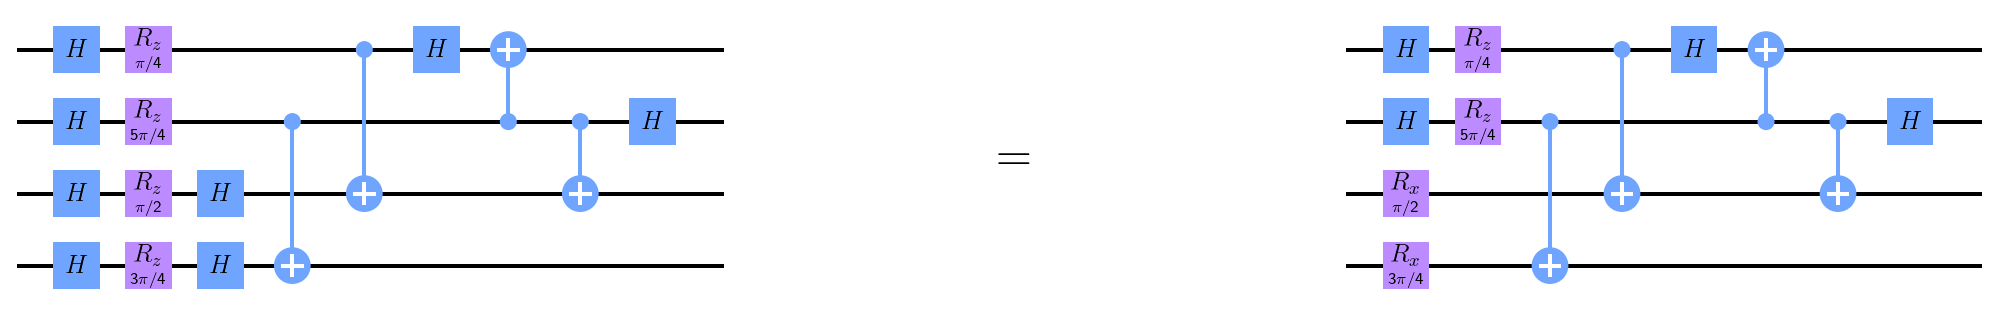

In [690]:
prove_circuit_identity(qc_opt9, qc_opt9_plus, circuit_margin=[0, 0, 0, 0], draw_matrix=False, grid_width_ratios=[5, 1, 5], constants=[sym.sqrt(2), sym.pi], tolerance=0.001, ignore_global_phase=True)

Although as pointed out by Elisa in the video this road doesn't get us to 45. We need to change strategy.  
Let's start over from our solution which granted us a score of 46.  
We can apply instead some identities between the rz gate of qbit 2 and the cx gates of qbit 0, 1, 2.  
We begin by applying identity6 to q2

Does circuit A matrix equals circuit B matrix? yes


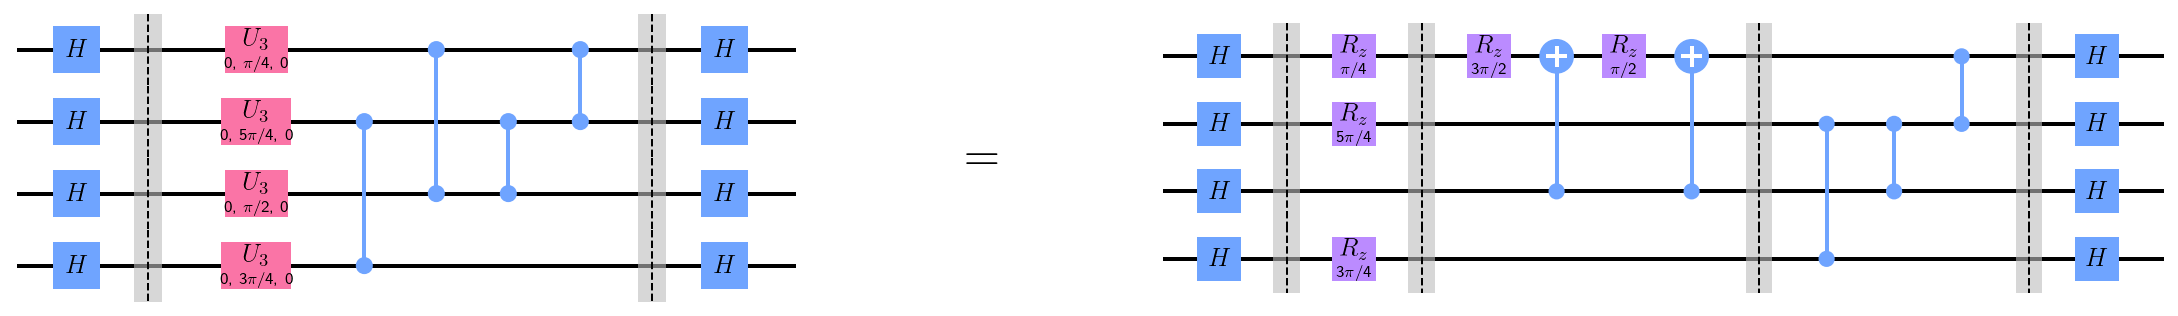

In [30]:
def optimized10():
    qc = QuantumCircuit(4)
    qc.h(num_qbit_list)
    qc.barrier()
    qc.rz(np.pi/4,0)
    qc.rz(5*np.pi/4,1)
    qc.rz(3*np.pi/4,3)
    
    qc.barrier()
    #replaced by the following
    #qc.rz(2*np.pi/4,2)
    #qc.cz(0, 2)
    qc.rz(3*np.pi/2,0)
    qc.cx(2,0)
    qc.rz(2*np.pi/4,0)
    qc.cx(2,0)
    qc.barrier()
    
    qc.cz(1, 3)
    qc.cz(1, 2)
    qc.cz(0, 1)
    qc.barrier()
    qc.h(num_qbit_list)

    return qc

qc_opt10 = optimized10()

prove_circuit_identity(qc_opt6, qc_opt10, circuit_margin=[0, 0, 0, 0], draw_matrix=False, grid_width_ratios=[8, 1, 10])

plt.show()

Apply identity7 to cz(1,2) and cz(0,1)

Does circuit A matrix equals circuit B matrix? yes


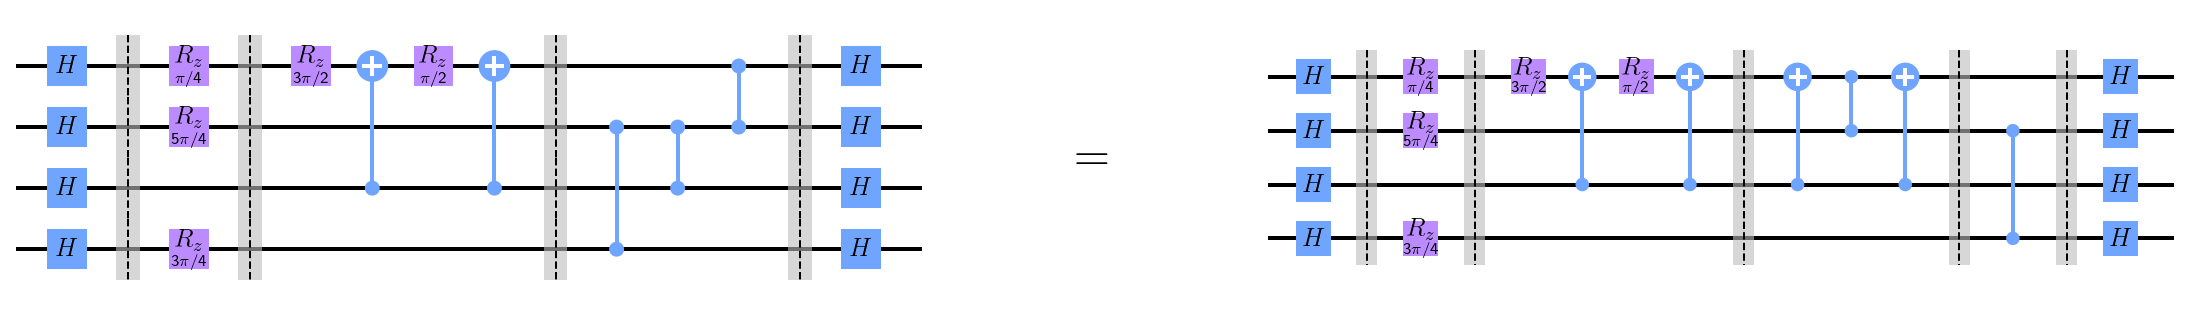

In [35]:
def optimized11():
    qc = QuantumCircuit(4)
    qc.h(num_qbit_list)
    qc.barrier()
    qc.rz(np.pi/4,0)
    qc.rz(5*np.pi/4,1)
    qc.rz(3*np.pi/4,3)
    
    qc.barrier()
    #replaced by the following
    #qc.rz(2*np.pi/4,2)
    #qc.cz(0, 2)
    qc.rz(3*np.pi/2,0)
    qc.cx(2,0)
    qc.rz(2*np.pi/4,0)
    qc.cx(2,0)
    
    qc.barrier()
    #replaced by the following
    #qc.cz(1, 2)
    #qc.cz(0, 1)
    qc.cx(2, 0)
    qc.cz(0, 1)
    qc.cx(2, 0)
    qc.barrier()
    
    qc.cz(1, 3)
    qc.barrier()
    qc.h(num_qbit_list)

    return qc

qc_opt11 = optimized11()

prove_circuit_identity(qc_opt10, qc_opt11, circuit_margin=[0, 0, 0, 0], draw_matrix=False, grid_width_ratios=[10, 1, 10])

plt.show()

Apply identity8 to cx(2,0) cx(2,0)

Does circuit A matrix equals circuit B matrix? yes


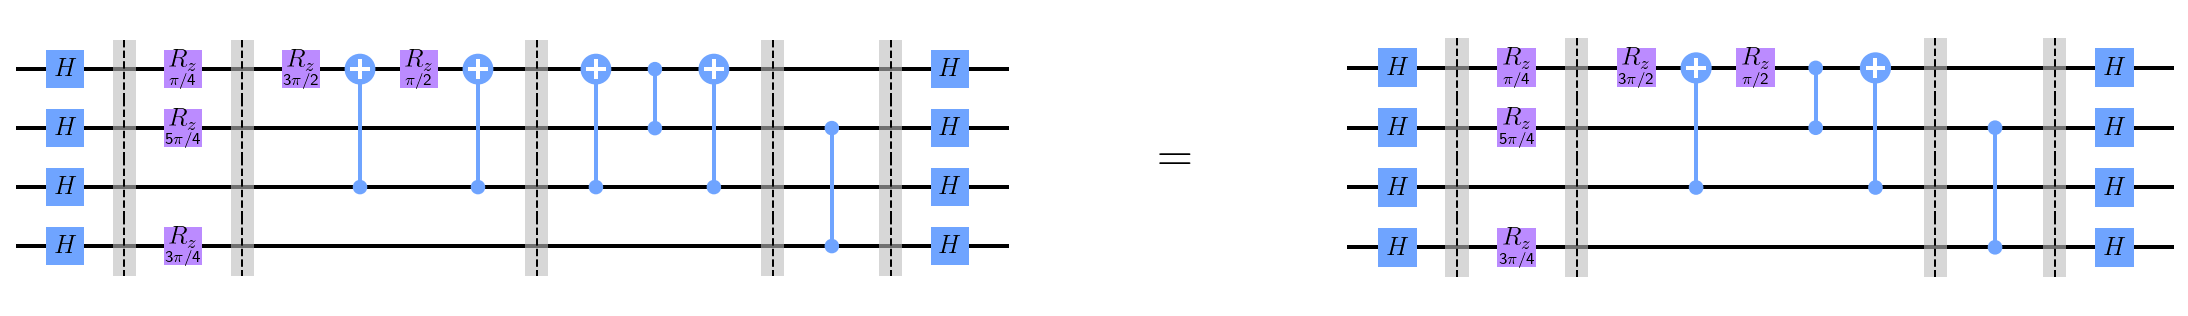

In [40]:
def optimized12():
    qc = QuantumCircuit(4)
    qc.h(num_qbit_list)
    qc.barrier()
    qc.rz(np.pi/4,0)
    qc.rz(5*np.pi/4,1)
    qc.rz(3*np.pi/4,3)
    
    qc.barrier()
    qc.rz(3*np.pi/2,0)
    qc.cx(2,0)
    qc.rz(2*np.pi/4,0)
    #removed
    #qc.cx(2,0)
    #removed
    #qc.barrier()
    #removed
    #qc.cx(2, 0)
    qc.cz(0, 1)
    qc.cx(2, 0)
    qc.barrier()
    
    qc.cz(1, 3)
    qc.barrier()
    qc.h(num_qbit_list)

    return qc

qc_opt12 = optimized12()

prove_circuit_identity(qc_opt11, qc_opt12, circuit_margin=[0, 0, 0, 0], draw_matrix=False, grid_width_ratios=[12, 1, 10])

plt.show()

Apply identity1 to cz(0,1) and identity3 to both of the cx(2,0)

Does circuit A matrix equals circuit B matrix? yes


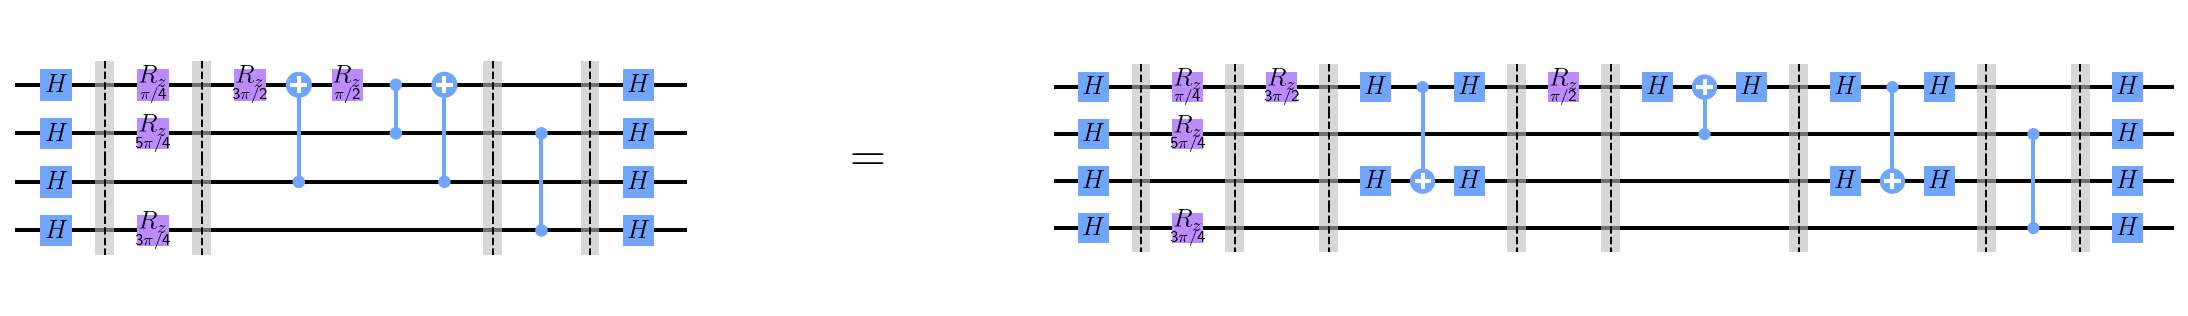

In [61]:
def optimized13():
    qc = QuantumCircuit(4)
    qc.h(num_qbit_list)
    qc.barrier()
    qc.rz(np.pi/4,0)
    qc.rz(5*np.pi/4,1)
    qc.rz(3*np.pi/4,3)
    
    qc.barrier()
    qc.rz(3*np.pi/2,0)
    qc.barrier()
    
    #replaced by the following
    #qc.cx(2,0)
    qc.h(0)#added
    qc.h(2)#added
    qc.cx(0,2)
    qc.h(0)#added
    qc.h(2)#added
    qc.barrier()
    
    qc.rz(2*np.pi/4,0)
    qc.barrier()
    
    #replaced by the following
    #qc.cz(0,1)
    qc.h(0)
    qc.cx(1,0)
    qc.h(0)
    qc.barrier()
    
    #qc.cx(2,0)
    qc.h(0)#added
    qc.h(2)#added
    qc.cx(0,2)
    qc.h(0)#added
    qc.h(2)#added
    qc.barrier()
    
    qc.cz(1, 3)
    qc.barrier()
    
    qc.h(num_qbit_list)

    return qc

qc_opt13 = optimized13()

prove_circuit_identity(qc_opt12, qc_opt13, circuit_margin=[0, 0, 0, 0], draw_matrix=False, grid_width_ratios=[6, 1, 10])

plt.show()

Apply identity9 to q0 (note: we ignore global phase)

Does circuit A matrix equals circuit B matrix? yes


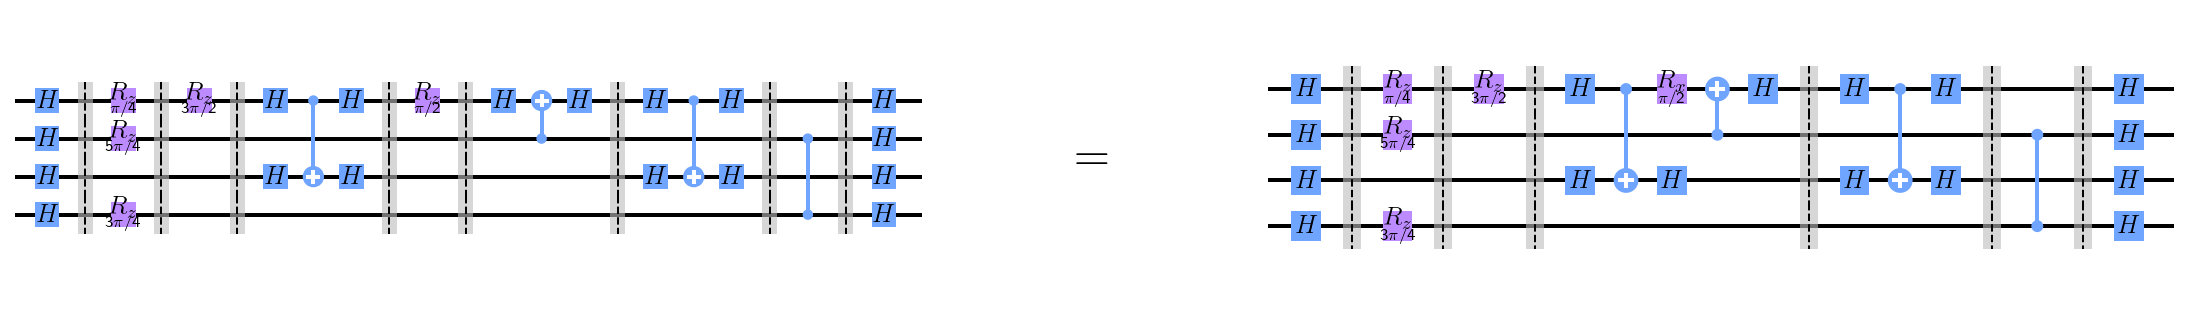

In [65]:
def optimized14():
    qc = QuantumCircuit(4)
    qc.h(num_qbit_list)
    qc.barrier()
    qc.rz(np.pi/4,0)
    qc.rz(5*np.pi/4,1)
    qc.rz(3*np.pi/4,3)
    
    qc.barrier()
    qc.rz(3*np.pi/2,0)
    qc.barrier()
    
    qc.h(0)
    qc.h(2)
    qc.cx(0,2)
    qc.h(2)
    qc.rx(2*np.pi/4,0)
    qc.cx(1,0)
    qc.h(0)
    qc.barrier()
    
    qc.h(0)
    qc.h(2)
    qc.cx(0,2)
    qc.h(0)
    qc.h(2)
    qc.barrier()
    
    qc.cz(1, 3)
    qc.barrier()
    
    qc.h(num_qbit_list)

    return qc

qc_opt14 = optimized14()

prove_circuit_identity(qc_opt13, qc_opt14, circuit_margin=[0, 0, 0, 0], draw_matrix=False, grid_width_ratios=[10, 1, 10], ignore_global_phase=True)

plt.show()

Apply identity4 and remove all the Hadamard gates next to each other.  
Also apply identity1 to cz(1, 3)

Does circuit A matrix equals circuit B matrix? yes


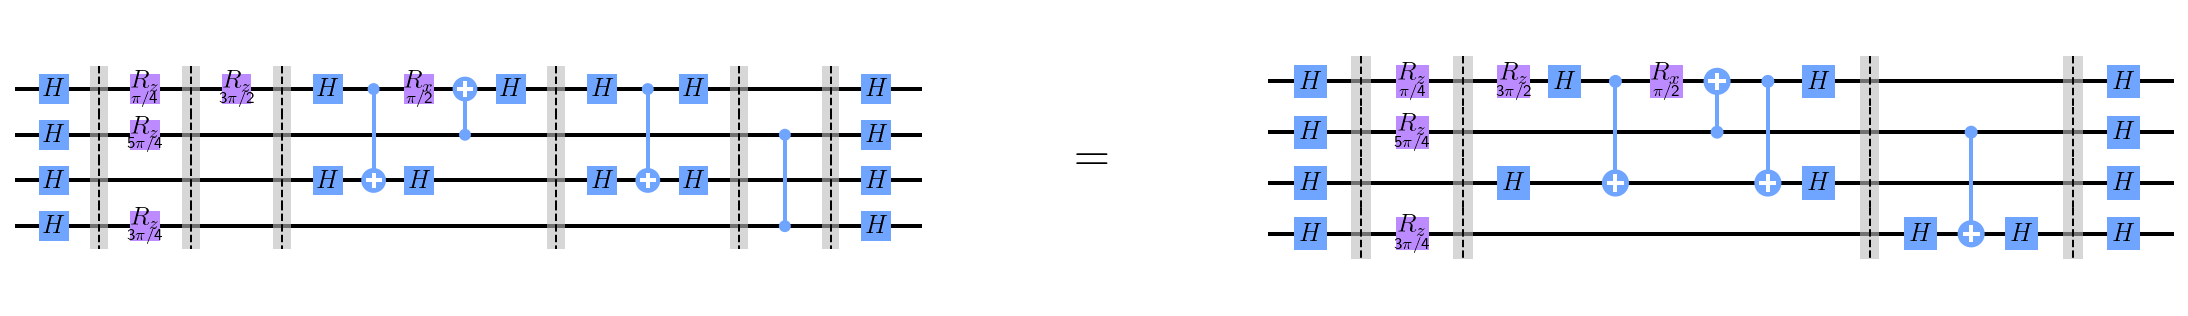

In [73]:
def optimized15():
    qc = QuantumCircuit(4)
    qc.h(num_qbit_list)
    qc.barrier()
    qc.rz(np.pi/4,0)
    qc.rz(5*np.pi/4,1)
    qc.rz(3*np.pi/4,3)
    
    qc.barrier()
    qc.rz(3*np.pi/2,0)    
    qc.h(0)
    qc.h(2)
    qc.cx(0,2)
    #qc.h(2) removed
    qc.rx(2*np.pi/4,0)
    qc.cx(1,0)
    #qc.h(0) removed
    #qc.h(0) removed
    #qc.h(2) removed
    qc.cx(0,2)
    qc.h(0)
    qc.h(2)
    qc.barrier()
    
    #qc.cz(1, 3) replaced
    qc.h(3)
    qc.cx(1,3)
    qc.h(3)
    qc.barrier()
    
    qc.h(num_qbit_list)

    return qc

qc_opt15 = optimized15()

prove_circuit_identity(qc_opt14, qc_opt15, circuit_margin=[0, 0, 0, 0], draw_matrix=False, grid_width_ratios=[10, 1, 10])

plt.show()

Apply identity5 for the two rz gates on q0

Does circuit A matrix equals circuit B matrix? yes


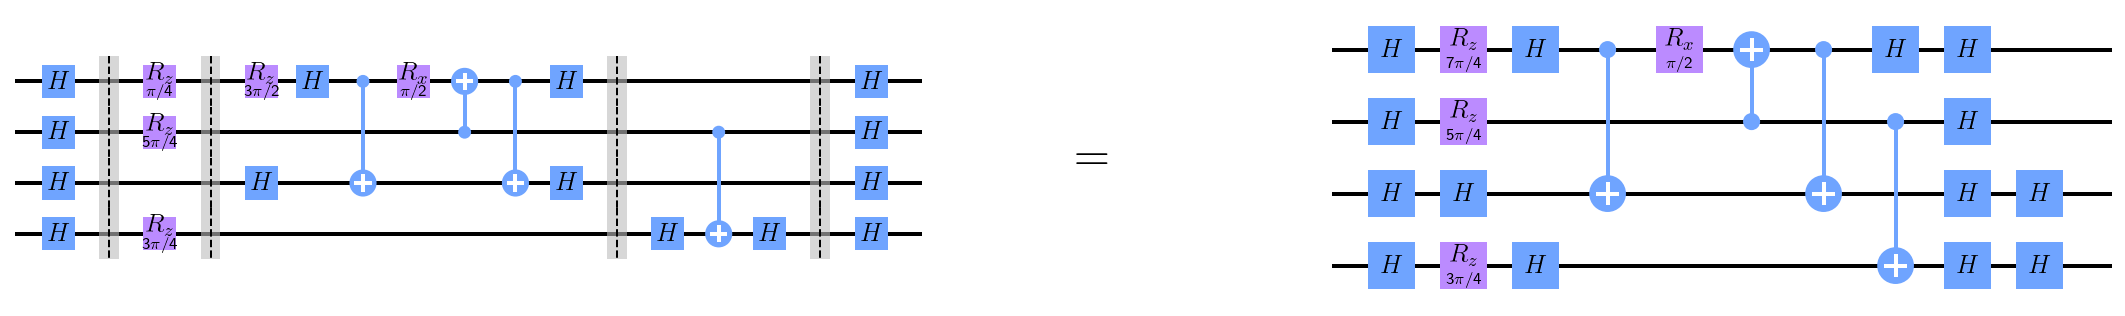

In [92]:
def optimized16():
    qc = QuantumCircuit(4)
    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    #qc.rz(np.pi/4,0) merged
    #qc.rz(3*np.pi/2,0) merged
    qc.rz(7*np.pi/4,0)
    qc.rz(5*np.pi/4,1)
    qc.rz(3*np.pi/4,3)
    qc.h(0)
    qc.h(2)
    qc.cx(0,2)
    qc.rx(2*np.pi/4,0)
    qc.cx(1,0)
    qc.cx(0,2)
    qc.h(0)
    qc.h(2)
    qc.h(3)
    qc.cx(1,3)
    qc.h(3)
    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(3)

    return qc

qc_opt16 = optimized16()

prove_circuit_identity(qc_opt15, qc_opt16, circuit_margin=[0, 0, 0, 0], draw_matrix=False, grid_width_ratios=[10, 1, 10])

plt.show()

 Apply identity9 on the rz gates on q4 and the just converted one on q0 (note: we ignore global phase)

Does circuit A matrix equals circuit B matrix? yes


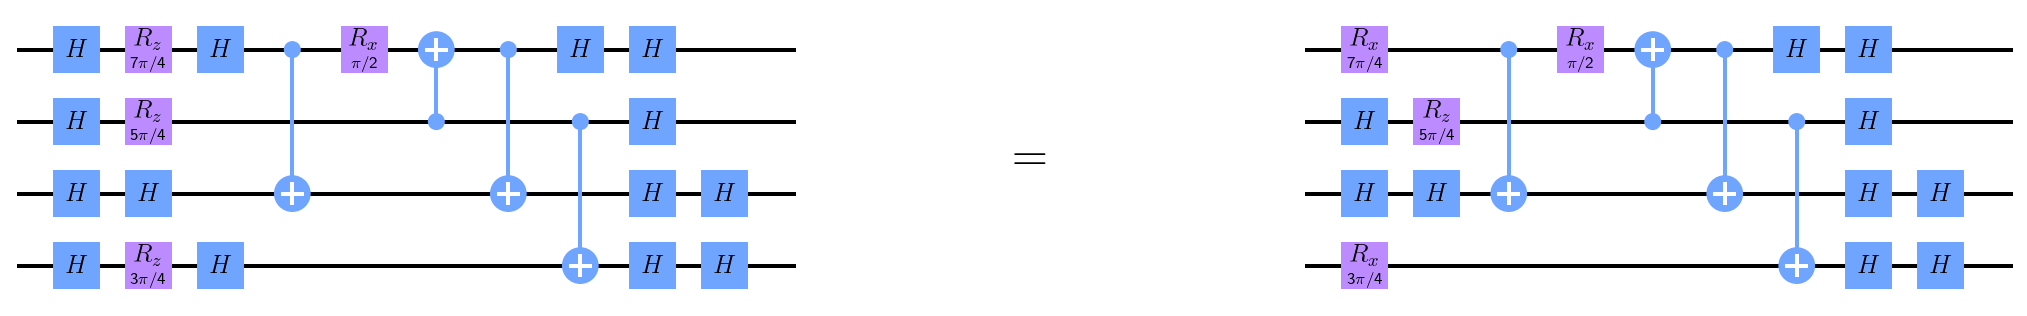

In [91]:
def optimized17():
    qc = QuantumCircuit(4)
    #qc.h(0) removed
    qc.h(1)
    qc.h(2)
    #qc.h(3) removed
    #qc.rz(7*np.pi/4,0) swapped
    qc.rx(7*np.pi/4,0)
    qc.rz(5*np.pi/4,1)
    #qc.rz(3*np.pi/4,3) swapped
    qc.rx(3*np.pi/4,3)
    #qc.h(0) removed
    qc.h(2)
    qc.cx(0,2)
    qc.rx(2*np.pi/4,0)
    qc.cx(1,0)
    qc.cx(0,2)
    qc.h(0)
    qc.h(2)
    #qc.h(3) removed
    qc.cx(1,3)
    qc.h(3)
    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(3)

    return qc

qc_opt17 = optimized17()

prove_circuit_identity(qc_opt16, qc_opt17, circuit_margin=[0, 0, 0, 0], draw_matrix=False, grid_width_ratios=[10, 1, 10], ignore_global_phase=True)

plt.show()

Apply identity4 to remove all the possible Hadamard gates

Does circuit A matrix equals circuit B matrix? yes


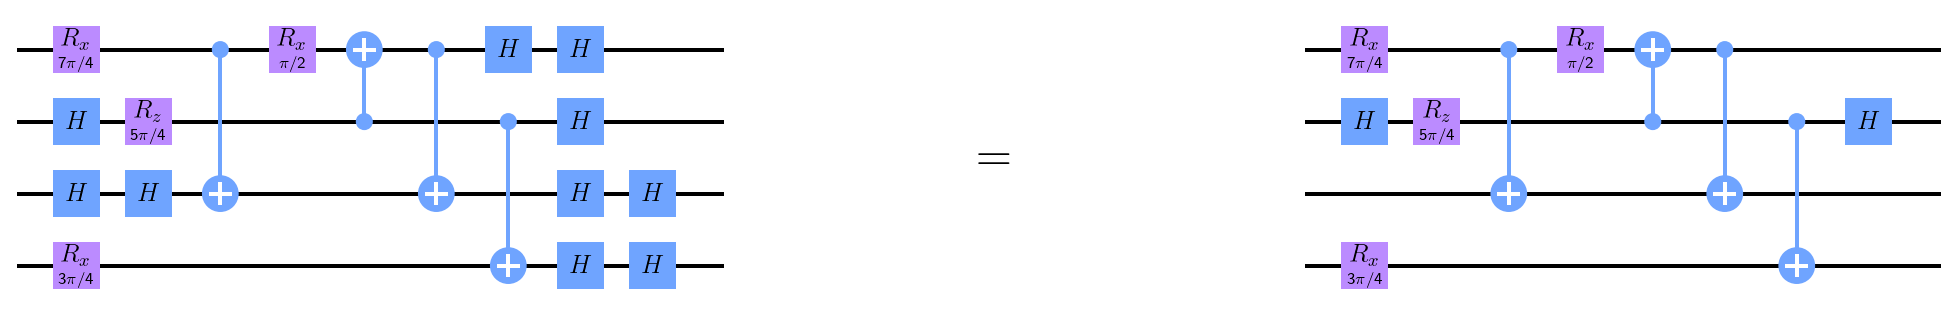

In [94]:
def optimized18():
    qc = QuantumCircuit(4)
    qc.h(1)
    #qc.h(2) removed
    qc.rx(7*np.pi/4,0)
    qc.rz(5*np.pi/4,1)
    qc.rx(3*np.pi/4,3)
    #qc.h(2) removed
    qc.cx(0,2)
    qc.rx(2*np.pi/4,0)
    qc.cx(1,0)
    qc.cx(0,2)
    #qc.h(0) removed
    #qc.h(2) removed
    qc.cx(1,3)
    #qc.h(3) removed
    #qc.h(0) removed
    qc.h(1)
    #qc.h(2) removed
    #qc.h(3) removed

    return qc

qc_opt18 = optimized18()

prove_circuit_identity(qc_opt17, qc_opt18, circuit_margin=[0, 0, 0, 0], draw_matrix=False, grid_width_ratios=[10, 1, 10])

plt.show()

We can reorder it to look exactly like the one shown in the video

Does circuit A matrix equals circuit B matrix? yes


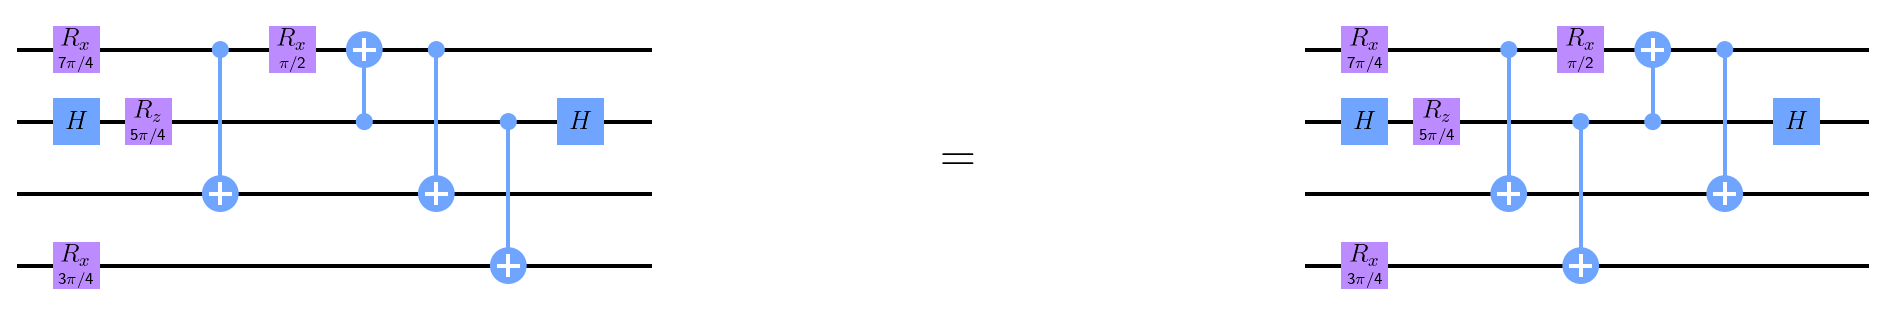

In [104]:
def optimized19():
    qc = QuantumCircuit(4)
    qc.h(1)
    qc.rx(7*np.pi/4,0)
    qc.rz(5*np.pi/4,1)
    qc.rx(3*np.pi/4,3)
    qc.cx(1,3)
    qc.cx(0,2)
    qc.rx(2*np.pi/4,0)
    qc.cx(1,0)
    qc.cx(0,2)
    qc.h(1)

    return qc

qc_opt19 = optimized19()

prove_circuit_identity(qc_opt18, qc_opt19, circuit_margin=[0, 0, 0, 0], draw_matrix=False, grid_width_ratios=[10, 1, 10])

plt.show()

As you can see the circuit drawers optimise it by moving the cx(1,3) under the Rx gate.
We can try and transpile it to see if it works.

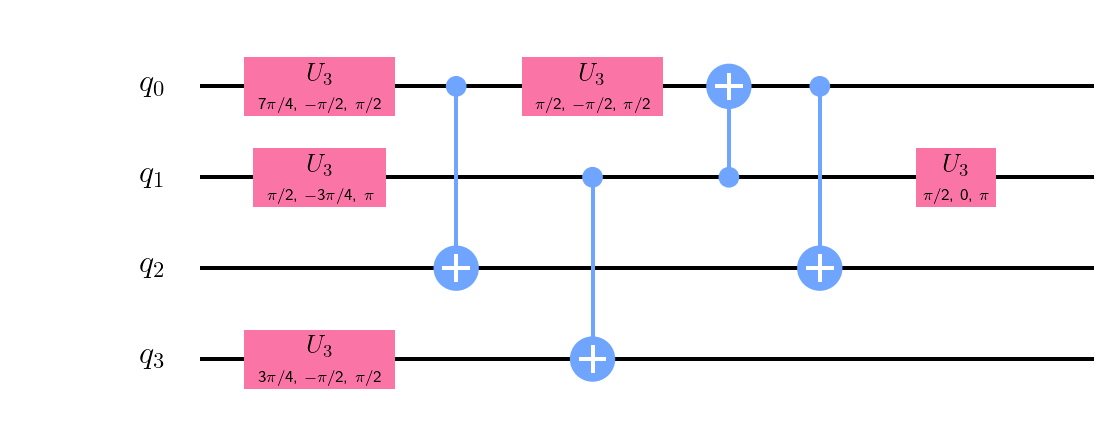

In [167]:
qc_opt19_t = transpile(qc_opt19, basis_gates = ['u3', 'cx'], optimization_level=3)
qc_opt19_t.draw(output='mpl')

In [168]:
check_circuit(qc_opt19_t)

Circuit stats:
||U-V||_2 = 1.4497854287631713e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 45

Great! Your circuit meets all the constrains.
Your score is 45. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


And it does! awesome. That's how you transpile a circuit manually by applying identities. I hope you learned something new and all of the demonstrations convinced you.

You can check whether your circuit is valid before submitting it with `check_circuit(qc)`. Once you have a valid solution, please submit it by running the following cell (delete the `#` before `submit_circuit`). You can re-submit at any time.


In [ ]:
# Send the circuit as the final answer, can re-submit at any time
#submit_circuit(qc) 